# Predicting Dengue Cases
***

* Student name: ***Aysu Erdemir***
* Student pace: ***Flex***
* Scheduled project review date/time: ***March, 2023***
* Instructor name: ***Abhineet Kulkarni***

## Overview:
***

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation; however the relationship to climate is known to be complex.  The way the disease spreads and causes endemics has significant public health implications worldwide.

- CDC is interested in predicting local epidemics of dengue fever so that they can take necessary precautions and efforts before the next spike. They want to know if we can predict the number of dengue fever cases reported each week in San Juan, Puerto Rico.

- My goal is to build several machine learning models to forecast the upcoming weekly dengue cases as accurately as possible.  

## Business and Data Understanding
***

* The data was obtained from [DrivenData](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/). The data set included weekly dengue case counts along with environmental data collected by various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce. 

* The full dataset included cases from year 1990 to 2008. The data from 2008-2013 included only features without case counts. 

* In this project I will be focusing on data on `Puerto Rico` only. The relevant variables/features included in the dataset are:

**Target Feature**: 
* `total_cases` - Weekly total dengue cases.

**Predictive Features**:

***Date Indicators***:

* `week_start_date` - Date given in yyyy-mm-dd format.

***NOAA's GHCN daily climate data weather station measurements***:

* `station_max_temp_c` - Maximum temperature
* `station_min_temp_c` - Minimum temperature
* `station_avg_temp_c` - Average temperature
* `station_precip_mm` - Total precipitation
* `station_diur_temp_rng_c` - Diurnal temperature range

***PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)***:

* `precipitation_amt_mm` - Total precipitation

***NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)***:

* `reanalysis_sat_precip_amt_mm` - Total precipitation
* `reanalysis_dew_point_temp_k` - Mean dew point temperature
* `reanalysis_air_temp_k` - Mean air temperature
* `reanalysis_relative_humidity_percent` - Mean relative humidity
* `reanalysis_specific_humidity_g_per_kg` - Mean specific humidity
* `reanalysis_precip_amt_kg_per_m2` - Total precipitation
* `reanalysis_max_air_temp_k` - Maximum air temperature
* `reanalysis_min_air_temp_k` - Minimum air temperature
* `reanalysis_avg_temp_k` - Average air temperature
* `reanalysis_tdtr_k` - Diurnal temperature range

***Satellite vegetation -greenness - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements***: 

* `ndvi_se` - Pixel southeast of city centroid
* `ndvi_sw` - Pixel southeast of city centroid
* `ndvi_ne` - Pixel southeast of city centroid
* `ndvi_nw` - Pixel southeast of city centroid

For example, when you have negative values, it’s highly likely that it’s water. On the other hand, if you have an NDVI value close to +1, there’s a high possibility that it’s dense green leaves. But when NDVI is close to zero, there are likely no green leaves and it could even be an urbanized area.

## Preprocessing: 
***

### Null Replacement:

* Null values for the climate features - except the four ndvi fatures - were imputed with **interpolation** since the missing data points are scarse.
* Null values for the four ndvi fatures were imputed using **k-Nearest Neighbors - KNN** since there were bigger chunks of missing values.

### Feature Engineering:

* Create `month` and `seasons`: Created new variables representing the month and seasons. 
* Create `average_ndvi` and its **categorical** version: Created a new feature representing the average NDVI values using the four different locations. Then created a categorical version of average_ndvi to represent watery, soily, sparce_grassy areas.
* Create **shifts** and **rolled averages** for the main climate variables:
Research seems to indicate that past sustained heat, precipitation or humidity impacts dengue cases more profoundly than the climate situation right at the time of cases. 
  - **Shifted** the variables by 2 weeks to account for the mosquito to reach adulthood and the incubation period of the virus until someone tests positive.
  - Engineered **rolled - cumulative** means over a period of time ranging from 1 weeks to 20 weeks to see the variable with the highest correlation. The lag with the highest corralation was kept in the final dataset. The final lags ranged from 2 months to 4 months.

**Some initial thoughts based on past research:**

**Precipitation:** 
- Mosquitos thrive wet climates, the wetter the better! 
- A rise in **accumulated rainfall** was shown to result in an increase in the number and quality of breeding sites. 
- Elevated relative risk of dengue was observed when the weekly average rainfall was more than 150 mm at **lagged weeks 12 to 20**.
- However, **above a certain rainfall level**, suitable mosquito breeding sites can be exposed to flooding, so the population is likely to decrease in such cases.

**Humidity:** 
- Humidity generates conditions that are favorable to adult mosquitoes increasing the life of the mosquito.   
- Humidity range of **60% - 90%** is the optimum moisture for growth and development of the Aedes aegypti mosquito. 

**Temperature:** 
- Mosquitoes more likely to transmit dengue virus in hot weather. Mosquitoes function best at 80 degrees F. **Higher temperatures (73-85°F)** results in more rapid viral growth and higher levels of virus. 
- The relative risk of dengue fever increases when the weekly average temperature is high **at lagged weeks 5 to 18**. 
- Under **fluctuating temperatures**, the mosquitoes show lower levels of virus in their salivary glands.
- **Extreme heat waves** can negatively impact mosquito life as very high temperatures  reduce adult lifespan and egg survival, resulting in reduced Aedes population and lower risk of dengue transmission.

**NDVI index:** 
- The relationship between  dengue epidemic and greenness indexes is not clear or consistent. 
- Some studies indicate increased density of vegetation to provide suitable habitat for the immature mosquitoes. 
- Others indicated that low vegetation cover areas with increased dengue incidence rates. This inconsistency may be explained by regional differences.


In [93]:
# Import required packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")
# check package versions when necessary:
# pd.__version__

# Data Exploration:
***

In [2]:
# load the files
from google.colab import files
uploaded = files.upload()

Saving dengue_labels_train.csv to dengue_labels_train (1).csv
Saving dengue_features_train.csv to dengue_features_train (1).csv
Saving dengue_features_test.csv to dengue_features_test (1).csv


In [3]:
# Read the Data
train_features = pd.read_csv("dengue_features_train.csv")
train_labels = pd.read_csv("dengue_labels_train.csv")
test_features = pd.read_csv("dengue_features_test.csv")


In [4]:
train_features.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990,18,4/30/90,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990,19,5/7/90,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990,20,5/14/90,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990,21,5/21/90,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990,22,5/28/90,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
train_labels.head()

,year,weekofyear,total_cases
0,1990,18,4
1,1990,19,5
2,1990,20,4
3,1990,21,3
4,1990,22,6


In [6]:
test_features.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,2008,18,4/29/08,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,2008,19,5/6/08,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,2008,20,5/13/08,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,2008,21,5/20/08,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,2008,22,5/27/08,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [7]:
# Merge the features dataset with the labels dataset (total cases) to form train. 
train = pd.merge(train_features, train_labels, on=[ "year", "weekofyear"])
train.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,4/30/90,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990,19,5/7/90,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990,20,5/14/90,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990,21,5/21/90,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990,22,5/28/90,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [8]:
# check row and column numbers
print(train_features.shape)
print(train_labels.shape)
print(train.shape)

(936, 23)
(936, 3)
(936, 24)


In [9]:
train.info()
# all variables are numerical except week_start_date which is an object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   year                                   936 non-null    int64  
 1   weekofyear                             936 non-null    int64  
 2   week_start_date                        936 non-null    object 
 3   ndvi_ne                                745 non-null    float64
 4   ndvi_nw                                887 non-null    float64
 5   ndvi_se                                917 non-null    float64
 6   ndvi_sw                                917 non-null    float64
 7   precipitation_amt_mm                   927 non-null    float64
 8   reanalysis_air_temp_k                  930 non-null    float64
 9   reanalysis_avg_temp_k                  930 non-null    float64
 10  reanalysis_dew_point_temp_k            930 non-null    float64
 11  reanal

In [10]:
train.total_cases.describe()
# Total weekly cases range from 0 to 461

count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

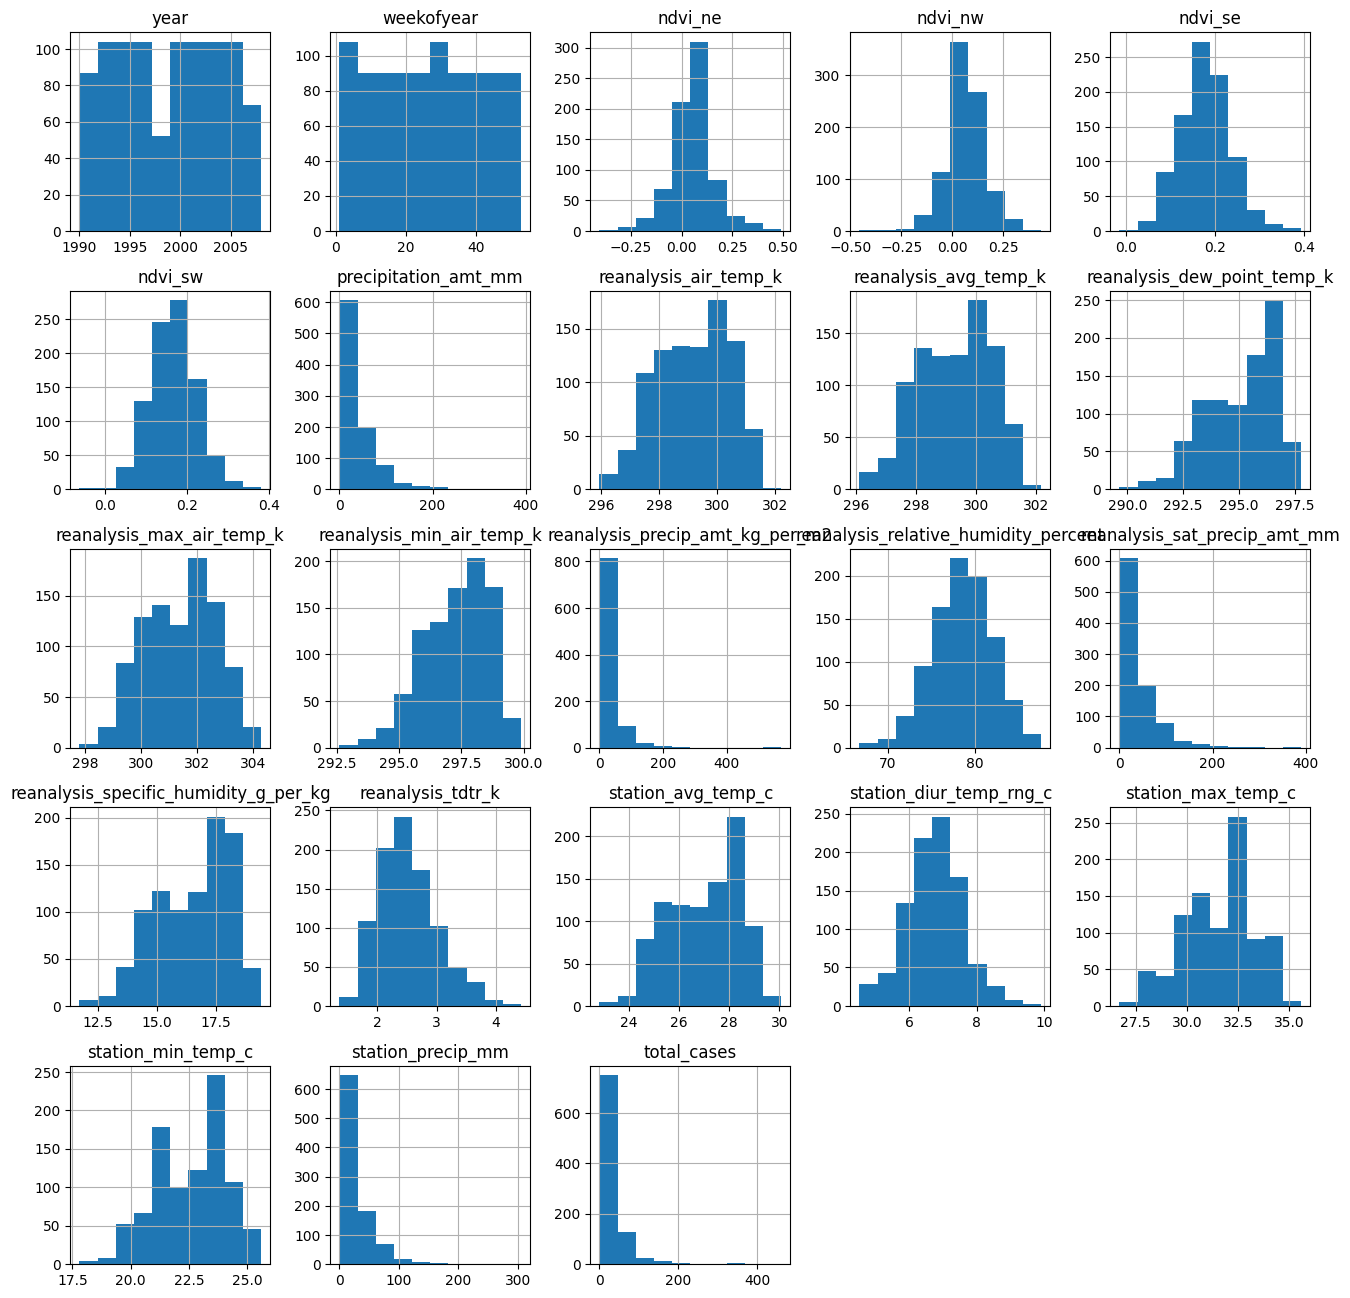

In [11]:
# Let's see the distribution of the data for each one of the variables. 
train.hist(figsize = (16,16));

* All feature variables seem to follow more or less a normal distribution except for precipitation fatures. 
* Precipitation follows a positive skew, where there are rare but extremely high values.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

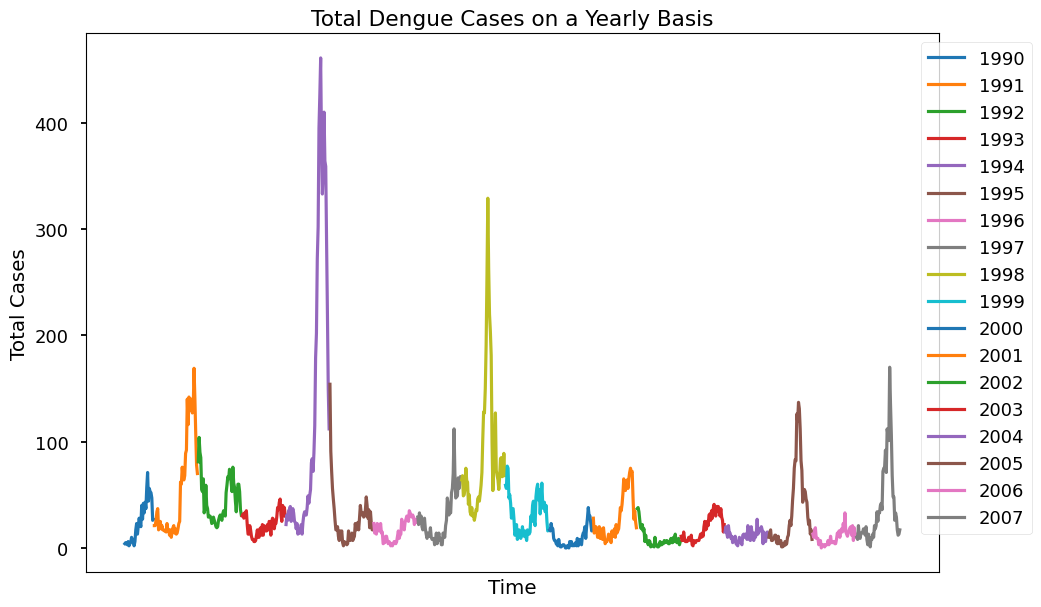

In [12]:
# See the distribution of case counts per each successive year:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(11,7)) 
    
    years = np.arange(1990,2008,1).astype(int)
    for year in years:
        sns.lineplot(data=train[train.year == year], 
                     x="week_start_date", y='total_cases', ax = ax, label = year)
        ax.get_xaxis().set_ticks([]) # hide week_start_date
        ax.set_xlabel('Time')
        ax.set_ylabel('Total Cases')
        ax.set_title('Total Dengue Cases on a Yearly Basis')
    fig.patch.set_alpha(0) # make the figure background transparent
    plt.legend(bbox_to_anchor=(1.12, 1), loc="upper right");
    fig.savefig('total_cases_years.png', dpi=300)
    files.download("total_cases_years.png") 

### Overall Summary:
* The data is from 1990 through 2008 with peak outbreaks at certain years. 
* Total weekly cases range from 0 to 461. 
* There are many null values, especially in ndvi index values. 
* Many of the temperature features coded more than once in celcius and fehrenheit using different data sources. 
* All variables appear as numerical except for week_start_date which is an object / string. 
* All variables appear as normally distributed except target variable and precipitation measures. 

## Check for null values:

In [13]:
train.isnull().sum()
# There are many null values

year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_pr

In [14]:
# Proportion of null values for each variable:
nulls = ((train.isnull().sum()*100) / len(train_features)).sort_values(ascending=False)
nulls[nulls > 0]

ndvi_ne                                  20.405983
ndvi_nw                                   5.235043
ndvi_se                                   2.029915
ndvi_sw                                   2.029915
precipitation_amt_mm                      0.961538
reanalysis_sat_precip_amt_mm              0.961538
reanalysis_min_air_temp_k                 0.641026
reanalysis_precip_amt_kg_per_m2           0.641026
station_avg_temp_c                        0.641026
reanalysis_tdtr_k                         0.641026
reanalysis_specific_humidity_g_per_kg     0.641026
reanalysis_relative_humidity_percent      0.641026
reanalysis_dew_point_temp_k               0.641026
station_min_temp_c                        0.641026
reanalysis_max_air_temp_k                 0.641026
station_max_temp_c                        0.641026
reanalysis_avg_temp_k                     0.641026
reanalysis_air_temp_k                     0.641026
station_precip_mm                         0.641026
station_diur_temp_rng_c        

### Display missing values: 

* **Missingno** library offers a very nice way to visualize the distribution of Null values.

<Axes: >

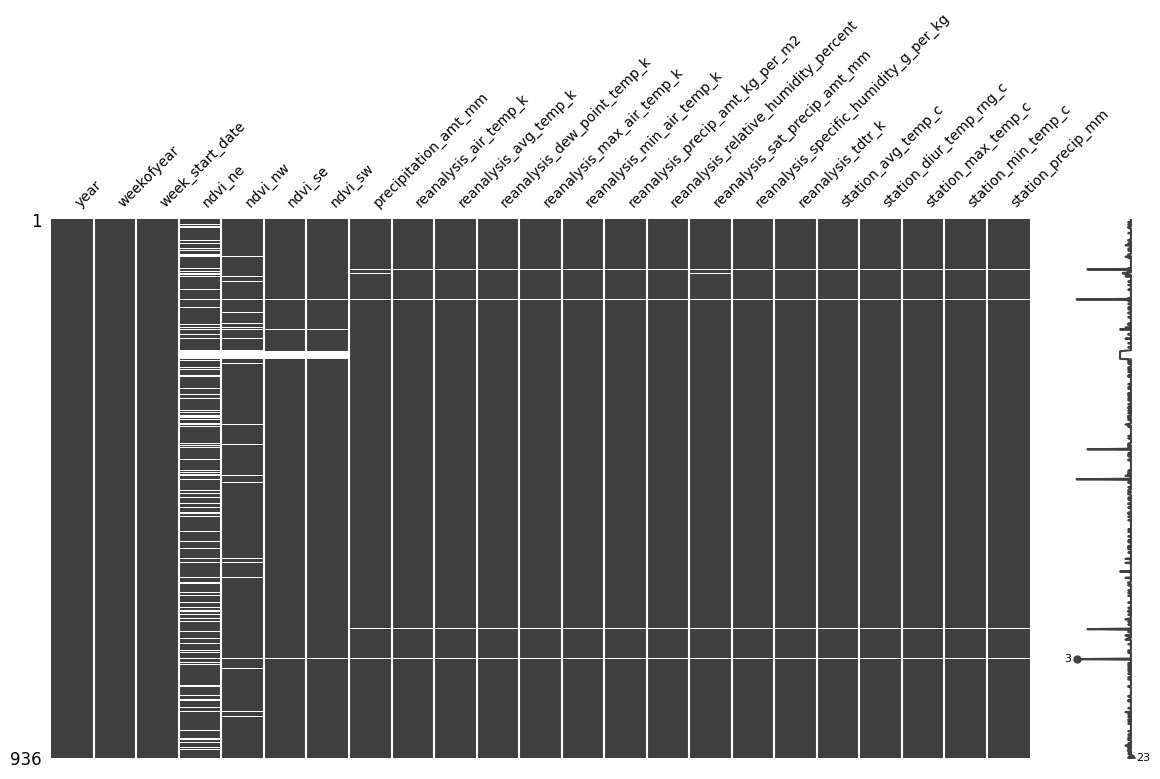

In [15]:
# Display null values across all rows/columns to check for specific patterns for the absence of data:
missingno.matrix(train_features , figsize=(14, 7), fontsize = 10)

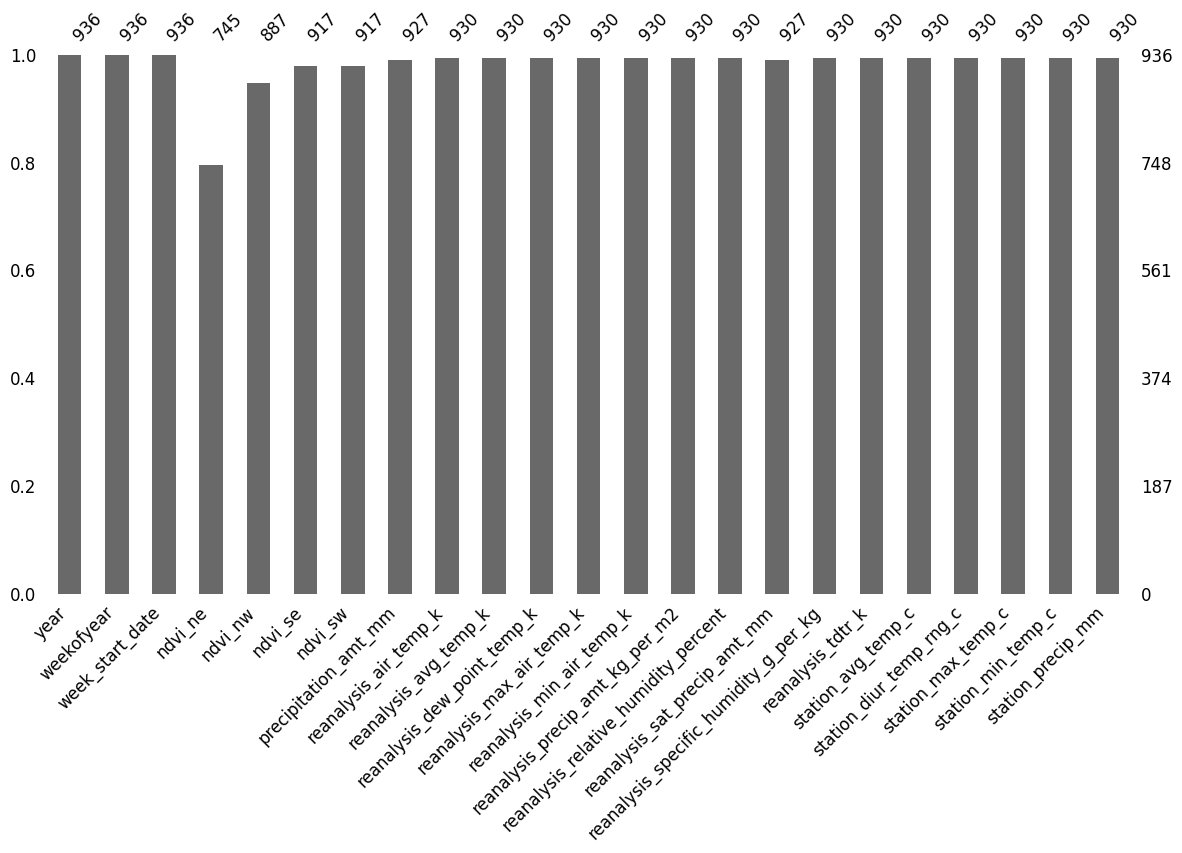

In [16]:
# let's see the same data with a bar chart
missingno.bar(train_features, figsize = (14,7), fontsize = 12);

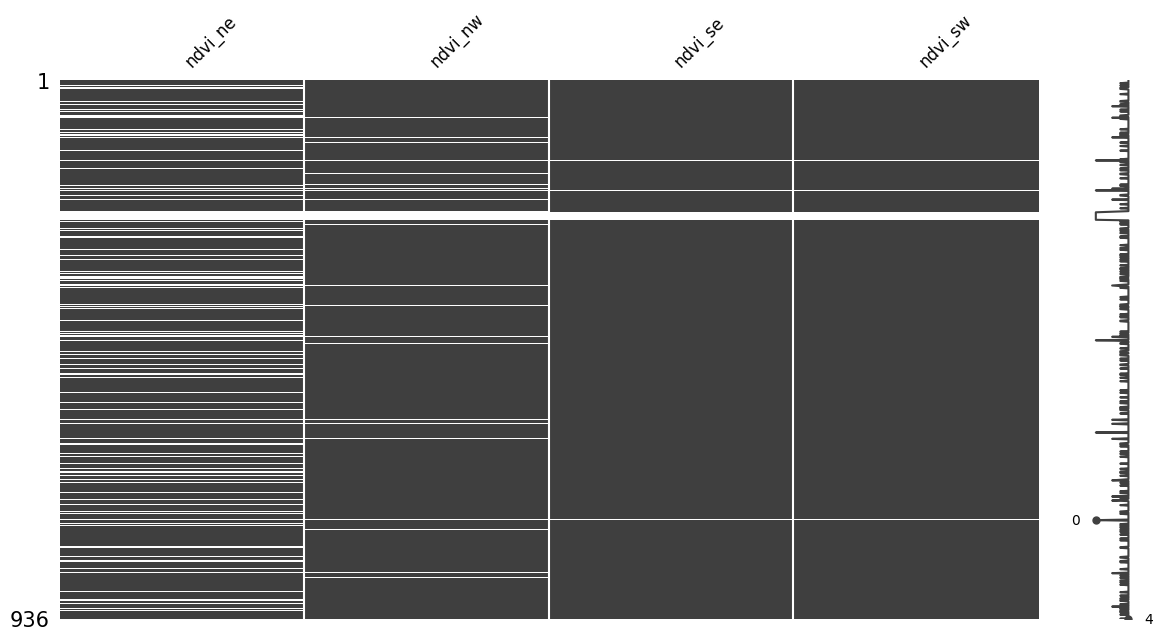

In [17]:
# Check the null matrix for the four variables with most null values to see if there is a pattern
missingno.matrix(train_features[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']],  figsize=(14, 7), fontsize = 12);

* Null values for most climate measures are scarce but ndvi indexes have null values in bigger chunks. 

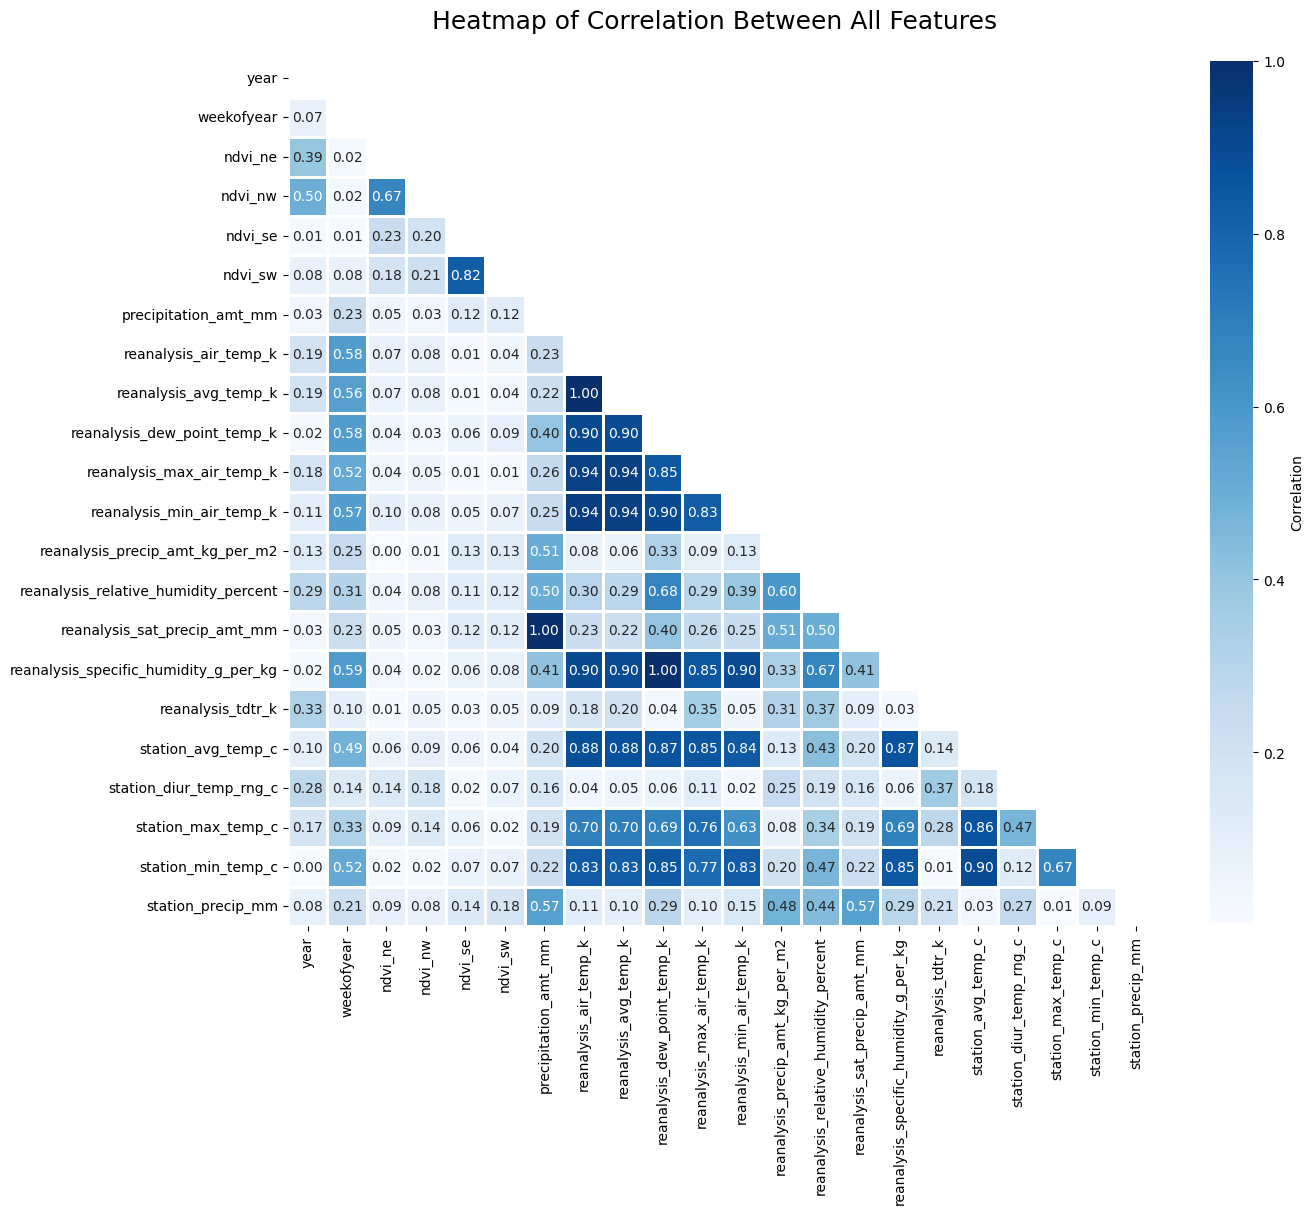

In [18]:
# Heat Map showing the correlation between all variables including the target
corr = train_features.corr().abs()
fig, ax = plt.subplots(figsize=(14,14))
matrix = np.triu(corr) # Getting the Lower Triangle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":0.8}
heatmap = sns.heatmap(data = corr,  linewidths = 1, square= True,  cmap='Blues', ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Features', fontsize=18, y=.84, x = .43);


* There are strong correlations among the majority of the variables. 


# Feature Engineering: Null Replacement

### Null replacement using **interpolatio**n and **predictive modeling**:

* We will replace the null values of all climate features except ndvi variables using **interpolation** since the missing data points are scarse. 
* We will replace the null values of features for ndvi variables using  **k-Nearest Neighbors** since there are bigger chunks of missing values.

In [19]:
# Null replacement with interpolation for the below variables:

train_features_interpolated = train_features

vars_to_interpolate = ['precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

for var in vars_to_interpolate:
    train_features_interpolated[var].interpolate(method ='linear', limit_direction ='forward', inplace = True)

#### Null replacement using KNN neighbours for the remaining ndvi variables:

* The default distance measure is a Euclidean distance measure that is NaN aware.
* The number of neighbors is set to five by default and can be configured by the “n_neighbors” argument.
* `week_start_date` column was dropped and the data was scaled before imputing using KNN neighbours. 
* After imputation, reversed the scaling to bring the values back to original scaling. 

In [20]:
# Drop `week_start_date` since we cannot work with this variable. 
train_features_interpolated = train_features_interpolated.drop("week_start_date", axis = 1)

In [21]:
# Scale the data first using StandardScaler
scaler = StandardScaler()
train_features_scaled = pd.DataFrame(scaler.fit_transform(train_features_interpolated), columns = train_features_interpolated.columns)
# Define imputer 
imputer = KNNImputer(n_neighbors=5)
# The fit imputer is applied to the dataset to create a copy of the dataset with all missing values for each column replaced with an estimated value.
train_features_imputed= pd.DataFrame(imputer.fit_transform(train_features_scaled), columns = train_features_scaled.columns)
# inverse the Standard Scaling
train_features_full = pd.DataFrame(scaler.inverse_transform(train_features_imputed), columns = train_features_imputed.columns)
train_features_full.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [22]:
# Making sure no null values remained
train_features_imputed.isna().sum().any() == 0

True

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

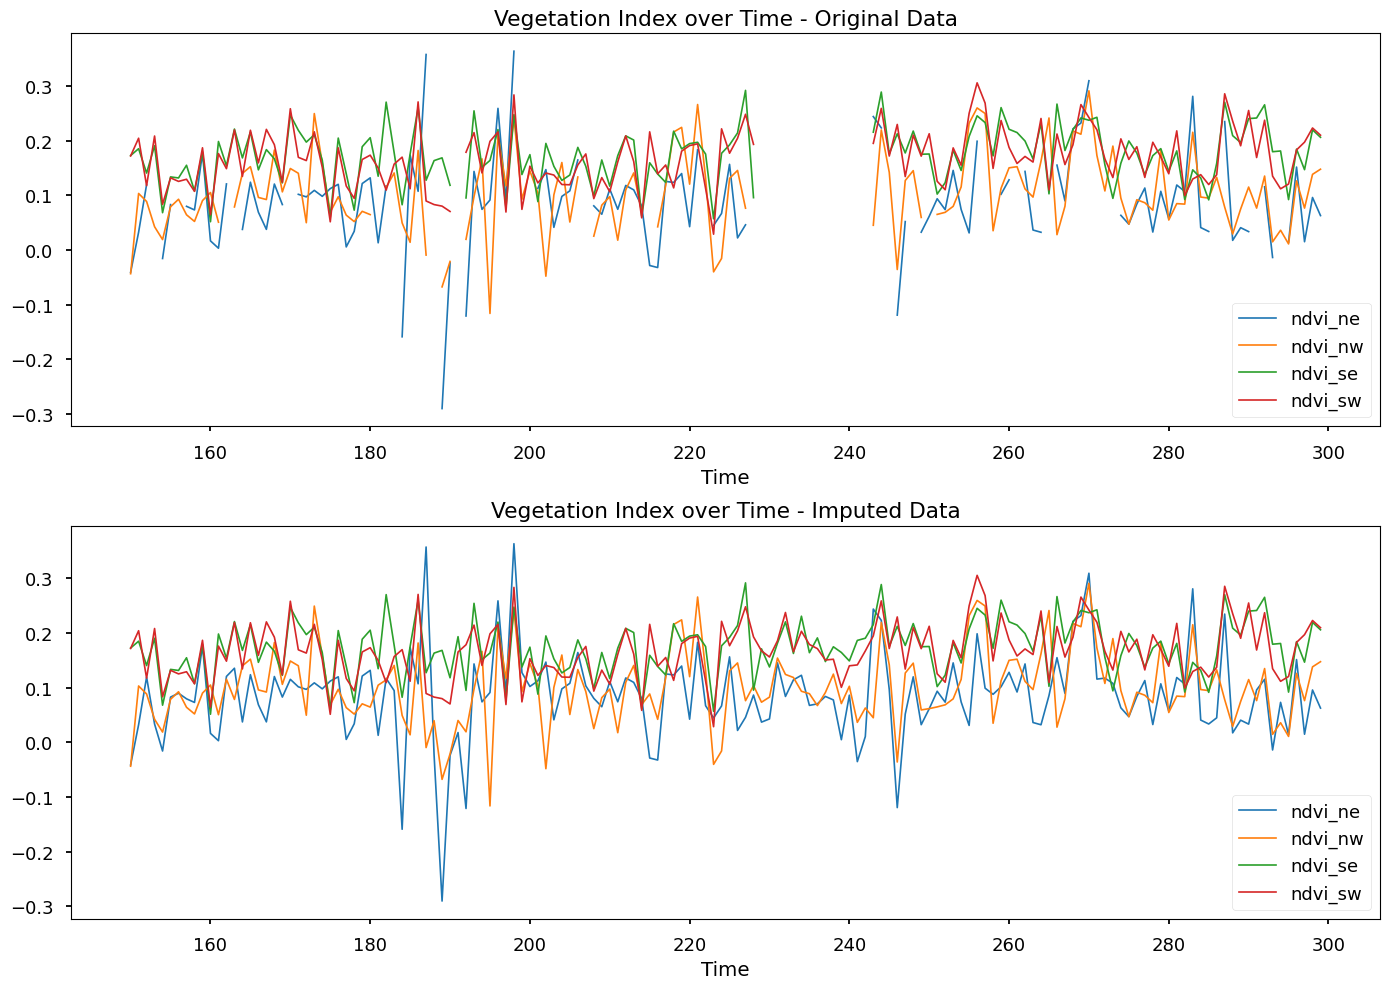

In [23]:
# Display the dataset for ndvi values before and after knn imputation
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,10))
    for var in ["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"]:
        train_features[150:300][var].plot.line(lw=1.2, ax = ax1)
    ax1.set_title('Vegetation Index over Time - Original Data')
    ax1.set_xlabel('Time')
    ax1.legend(loc='lower right')  
    for var in ["ndvi_ne", "ndvi_nw", "ndvi_se", "ndvi_sw"]:
        train_features_full[150:300][var].plot.line(lw=1.2, ax = ax2)
    ax2.set_title('Vegetation Index over Time - Imputed Data')
    ax2.set_xlabel('Time')
    ax2.legend(loc='lower right')
    fig.tight_layout();  
    fig.patch.set_alpha(0) # make the figure background transparent
    fig.savefig('KNN_ndvi.png', dpi=300, bbox_inches='tight')
    files.download("KNN_ndvi.png")   

In [24]:
# Merge the imnputed dataset with the labels
train_full = pd.merge(train_features_full, train_labels, on=[ "year", "weekofyear"])
train_full.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


## Repeat all **imputation** steps for the test_features dataset:

In [25]:
# See how many null values present in the test dataset
test_features.isnull().sum()

year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                        2
station_diur_temp_rng_c                   2
station_max_temp_c                        2
station_min_temp_c                        2
station_precip_mm               

In [26]:
# Interpolation
test_features_interpolated = test_features
for var in vars_to_interpolate:
    test_features_interpolated[var].interpolate(method ='linear', limit_direction ='forward', inplace = True)

# Drop week_start_date:
test_features_interpolated = test_features_interpolated.drop("week_start_date", axis = 1)

# Scale, imputer using KNN inputer, inverse scale
test_features_scaled = pd.DataFrame(scaler.fit_transform(test_features_interpolated), columns = test_features_interpolated.columns)
test_features_imputed = pd.DataFrame(imputer.fit_transform(test_features_scaled), columns = test_features_scaled.columns)
test_features_full = pd.DataFrame(scaler.inverse_transform(test_features_imputed), columns = test_features_imputed.columns)

# Making sure no null values remained
test_features_full.isna().sum().any() == 0

True

Full Imputed datasets are:
* train_full
* test_features_full

# Feature Engineering: Feature Selection / Creation

In [27]:
train_featured = train_full.copy()

#### Let's create a new `month` variable and dummy coded `season` variables:

In [28]:
# Add `the week_start_date` column from the original dataset to the new dataset
train_featured['week_start_date'] = train_features['week_start_date']

In [29]:
# create a new month variable:
train_featured["week_start_date"] = pd.to_datetime(train_featured["week_start_date"])
train_featured['month'] = train_featured['week_start_date'].dt.month

In [30]:
# create a new season variable:
seasons = ["winter", "winter", "spring", "spring", "spring", 
           "summer", "summer", "summer", "fall", "fall", "fall", "winter"]

month_to_season = dict(zip(range(1,13), seasons))
month_to_season 

train_featured['season'] = train_featured['month'].map(month_to_season) 

In [31]:
# See the new variables:
train_featured[['week_start_date','month','season']].sample(5)

,week_start_date,month,season
485,1999-08-27,8,summer
327,1996-08-12,8,summer
566,2001-03-19,3,spring
892,2007-06-25,6,summer
671,2003-03-26,3,spring


In [32]:
# Get the season dummy coded
season_features = pd.get_dummies(train_featured['season'])
train_featured = pd.concat([train_featured, season_features], axis = 1)
train_featured.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_min_temp_c,station_precip_mm,total_cases,week_start_date,month,season,fall,spring,summer,winter
0,1990.0,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,20.0,16.0,4,1990-04-30,4,spring,0,1,0,0
1,1990.0,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,22.2,8.6,5,1990-05-07,5,spring,0,1,0,0
2,1990.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,22.8,41.4,4,1990-05-14,5,spring,0,1,0,0
3,1990.0,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,23.3,4.0,3,1990-05-21,5,spring,0,1,0,0
4,1990.0,22.0,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,23.9,5.8,6,1990-05-28,5,spring,0,1,0,0


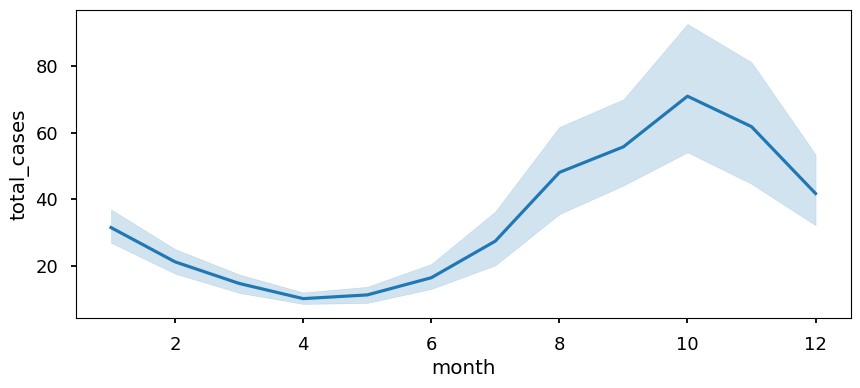

In [33]:
# Seasonality: See the distribution of case counts on a monthly basis:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,4)) 
    sns.lineplot(data=train_featured, x="month", y='total_cases', ax = ax) 
# Maximum number of cases are usually are seen in the fall.

# Feature elimination / selection:

In [34]:
# Show the correlated pairs starting with strongest correlations:
dataCorr = train_featured.drop('total_cases',axis =1).corr().abs()
dataCorr = dataCorr.mask(np.triu(np.ones(dataCorr.shape)).astype(bool)) # convert upper triangle of values to NaN to remove repeated values from the table
dataCorr = dataCorr.stack().reset_index().sort_values(0, ascending=False) #0 is the column automatically generated by the stacking
dataCorr = dataCorr[(dataCorr[0]>.8) & (dataCorr[0]<1)]
dataCorr =  dataCorr.rename(columns = {'level_0': 'var_1', 'level_1': 'var_2', 0:'corr_coef'})
dataCorr

,var_1,var_2,corr_coef
114,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,0.998533
35,reanalysis_avg_temp_k,reanalysis_air_temp_k,0.997507
232,month,weekofyear,0.955143
62,reanalysis_min_air_temp_k,reanalysis_air_temp_k,0.942248
53,reanalysis_max_air_temp_k,reanalysis_avg_temp_k,0.939202
63,reanalysis_min_air_temp_k,reanalysis_avg_temp_k,0.939127
52,reanalysis_max_air_temp_k,reanalysis_air_temp_k,0.935339
112,reanalysis_specific_humidity_g_per_kg,reanalysis_air_temp_k,0.905004
43,reanalysis_dew_point_temp_k,reanalysis_air_temp_k,0.903481
64,reanalysis_min_air_temp_k,reanalysis_dew_point_temp_k,0.899008


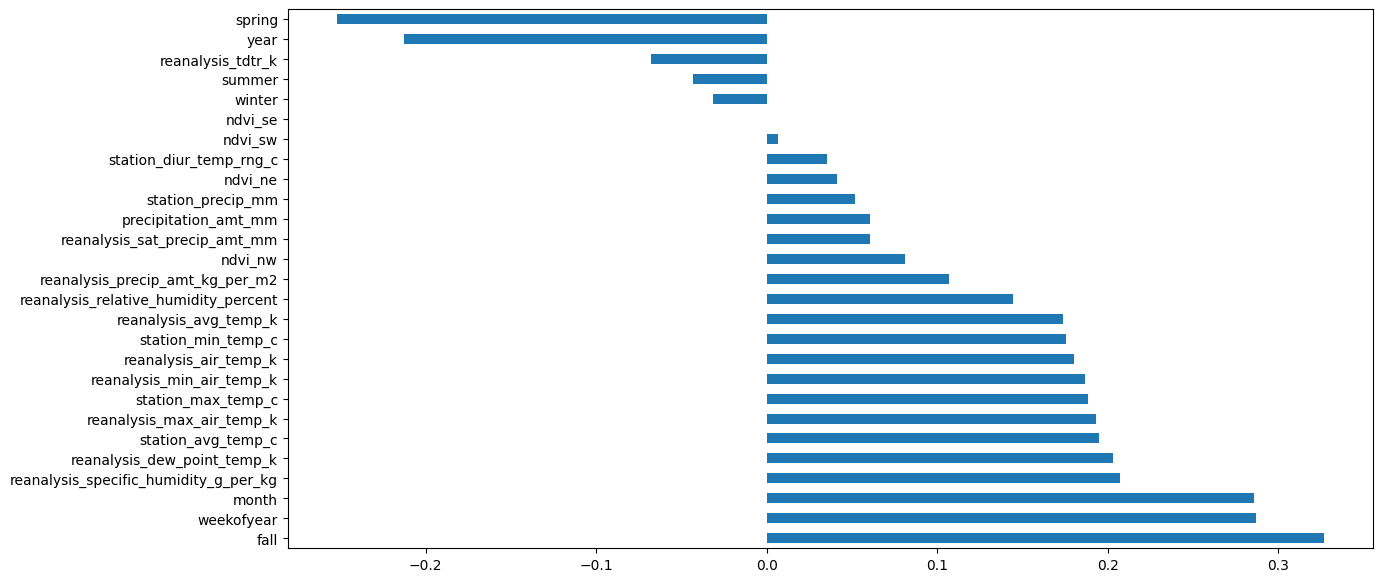

In [35]:
# Show how strongly the features are correlated with the target variable - total cases:
fig, ax = plt.subplots(figsize=(14,7))
train_featured.corr()['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh(ax=ax);

* Many of the temperature data are strongly correlated with one another especially because the same feature was coded multiple times from different resources. 
* However, none of the features seem to have a strong relationship with the target variable - total_cases. Total_cases seems to only have weak correlations with other variables. 
* We need to engineer some new features hoping they would have stronger relationship with total_cases.


### Select the best average temperature variable:
* `station_avg_temp_c` has the strongest correlation 

In [36]:
# see the correlations among all average temperature variables:
train_featured[['total_cases','station_avg_temp_c','reanalysis_air_temp_k','reanalysis_avg_temp_k']].corr()

,total_cases,station_avg_temp_c,reanalysis_air_temp_k,reanalysis_avg_temp_k
total_cases,1.000000,0.194823,0.180311,0.173670
station_avg_temp_c,0.194823,1.000000,0.880871,0.879118
reanalysis_air_temp_k,0.180311,0.880871,1.000000,0.997507
reanalysis_avg_temp_k,0.173670,0.879118,0.997507,1.000000


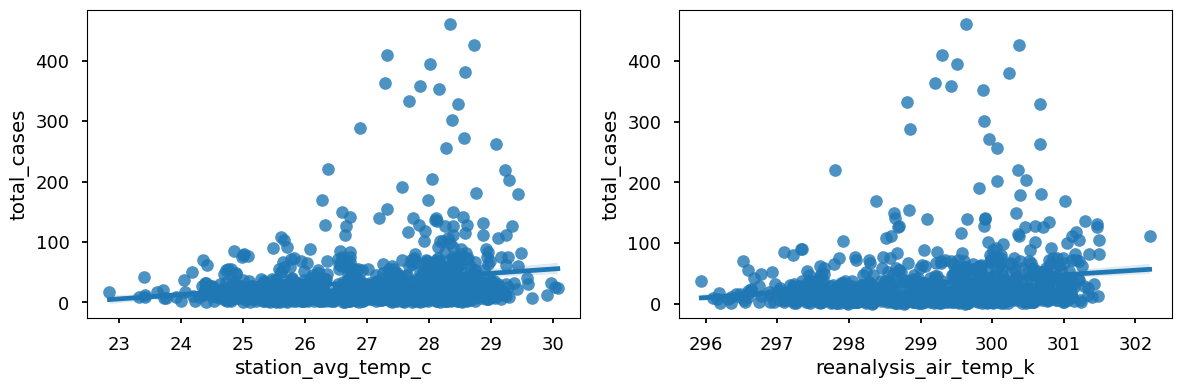

In [37]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14,4)) 
    sns.regplot(data=train_featured, x="station_avg_temp_c", y='total_cases', ax = ax1, label = 'station_avg_temp_c') 
    sns.regplot(data=train_featured, x="reanalysis_air_temp_k", y='total_cases', ax = ax2, label = 'reanalysis_air_temp_k')
    

### Select the best daily temperature change variable:
* `reanalysis_tdtr_k` has the strongest correlation 
* Let's also replace the single outlier with a better value. 

In [38]:
train_featured[['total_cases','station_diur_temp_rng_c','reanalysis_tdtr_k']].corr()

,total_cases,station_diur_temp_rng_c,reanalysis_tdtr_k
total_cases,1.000000,0.035303,-0.067623
station_diur_temp_rng_c,0.035303,1.000000,0.372414
reanalysis_tdtr_k,-0.067623,0.372414,1.000000


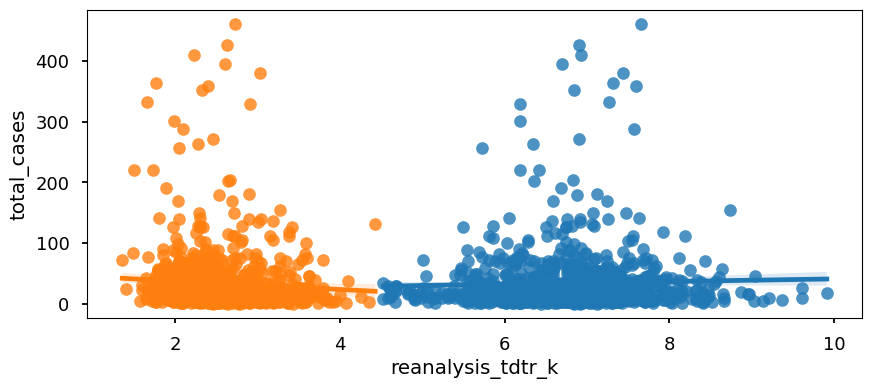

In [39]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,4)) 
    sns.regplot(data=train_featured, x="station_diur_temp_rng_c", y='total_cases', ax = ax, label = 'station_diur_temp_rng_c') 
    sns.regplot(data=train_featured, x="reanalysis_tdtr_k", y='total_cases', ax = ax, label = 'reanalysis_tdtr_k')
    

In [40]:
# check out the outlier for 'reanalysis_tdtr_k':
train_featured[train_featured['reanalysis_tdtr_k'] == train_featured['reanalysis_tdtr_k'].max()]

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_min_temp_c,station_precip_mm,total_cases,week_start_date,month,season,fall,spring,summer,winter
799,2005.0,36.0,0.0022,-0.0271,0.205029,0.220233,23.3,301.465714,301.514286,296.642857,...,24.4,8.9,131,2005-09-10,9,fall,1,0,0,0


In [41]:
# replace the outlier with the previous value in the series
train_featured = train_featured.replace(train_featured['reanalysis_tdtr_k'].max(), method='ffill')
train_featured[799:800]

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,station_min_temp_c,station_precip_mm,total_cases,week_start_date,month,season,fall,spring,summer,winter
799,2005.0,36.0,0.0022,-0.0271,0.205029,0.220233,23.3,301.465714,301.514286,296.642857,...,24.4,8.9,131,2005-09-10,9,fall,1,0,0,0


In [42]:
# check the correlations again:
train_featured[['total_cases','station_diur_temp_rng_c','reanalysis_tdtr_k']].corr()

,total_cases,station_diur_temp_rng_c,reanalysis_tdtr_k
total_cases,1.000000,0.035303,-0.073160
station_diur_temp_rng_c,0.035303,1.000000,0.374047
reanalysis_tdtr_k,-0.073160,0.374047,1.000000


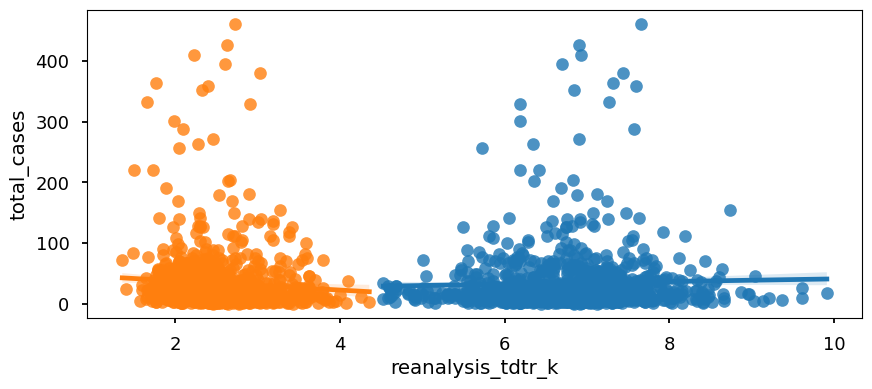

In [43]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,4)) 
    sns.regplot(data=train_featured, x="station_diur_temp_rng_c", y='total_cases', ax = ax, label = 'station_diur_temp_rng_c') 
    sns.regplot(data=train_featured, x="reanalysis_tdtr_k", y='total_cases', ax = ax, label = 'reanalysis_tdtr_k')
    

### Select the best humidity variable:
* `reanalysis_specific_humidity_g_per_kg` has the strongest correlation 

In [44]:
train_featured[['total_cases','reanalysis_relative_humidity_percent',
                'reanalysis_specific_humidity_g_per_kg','reanalysis_dew_point_temp_k']].corr()

,total_cases,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k
total_cases,1.000000,0.144404,0.206942,0.202807
reanalysis_relative_humidity_percent,0.144404,1.000000,0.673010,0.678116
reanalysis_specific_humidity_g_per_kg,0.206942,0.673010,1.000000,0.998533
reanalysis_dew_point_temp_k,0.202807,0.678116,0.998533,1.000000


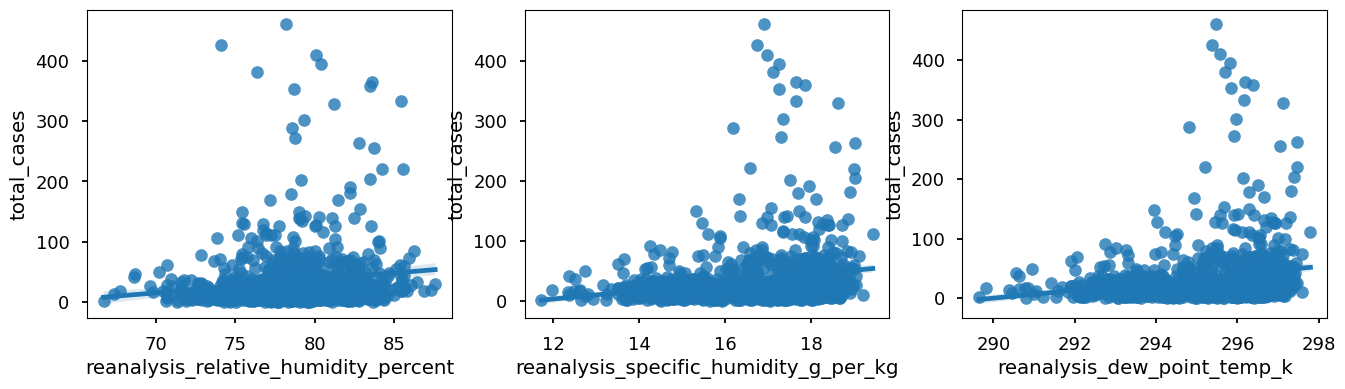

In [45]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows = 1, figsize=(16,4)) 
    sns.regplot(data=train_featured, x="reanalysis_relative_humidity_percent", y='total_cases', ax = ax1, label = 'reanalysis_relative_humidity_percent')
    sns.regplot(data=train_featured, x="reanalysis_specific_humidity_g_per_kg", y='total_cases', ax = ax2, label = 'reanalysis_specific_humidity_g_per_kg') 
    sns.regplot(data=train_featured, x="reanalysis_dew_point_temp_k", y='total_cases', ax = ax3, label = 'reanalysis_dew_point_temp_k')
    

### Select the best precipitation variable:
* `reanalysis_precip_amt_kg_per_m2` has the strongest correlation 

In [46]:
train_featured[['total_cases','reanalysis_sat_precip_amt_mm','station_precip_mm',
                'reanalysis_precip_amt_kg_per_m2', 'precipitation_amt_mm']].corr()

,total_cases,reanalysis_sat_precip_amt_mm,station_precip_mm,reanalysis_precip_amt_kg_per_m2,precipitation_amt_mm
total_cases,1.000000,0.060296,0.051883,0.106939,0.060296
reanalysis_sat_precip_amt_mm,0.060296,1.000000,0.566660,0.508274,1.000000
station_precip_mm,0.051883,0.566660,1.000000,0.477984,0.566660
reanalysis_precip_amt_kg_per_m2,0.106939,0.508274,0.477984,1.000000,0.508274
precipitation_amt_mm,0.060296,1.000000,0.566660,0.508274,1.000000


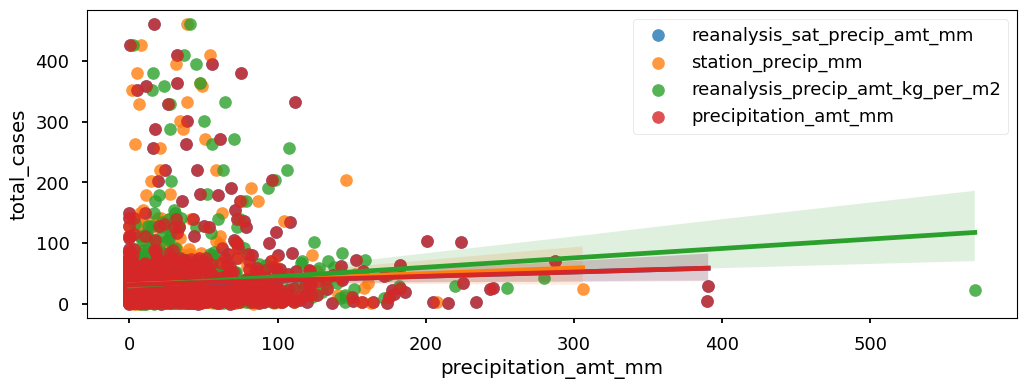

In [47]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(12,4)) 
    for var in ["reanalysis_sat_precip_amt_mm","station_precip_mm", "reanalysis_precip_amt_kg_per_m2", "precipitation_amt_mm"]:
      sns.regplot(data=train_featured, x=var, y='total_cases', ax = ax, label = var) 
      plt.legend()


## Summary - feature selection:

Let's focus on these variables below since they provide the highest correlations. Let's keep all the temperature variables same scale (celcius) for interpretability except the diurnal which gave better correlation in kelvin. 

Using NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale):

**Temperature variables**: `station_avg_temp_c`,`station_min_temp_c`, `station_max_temp_c`, `reanalysis_tdtr_k` (Diurnal temperature range)

**Humidity**:   `reanalysis_specific_humidity_g_per_kg`

**Precipitation**:  `reanalysis_precip_amt_kg_per_m2` (Total precipitation)

**Vegetation:**  `ndvi_ne`, `ndvi_nw`, `ndvi_se`, `ndvi_sw`

In [48]:
# Keeping the below variables as primary:
train_featured = train_featured[['total_cases', 'year', 'weekofyear', 'week_start_date', 
                                 'month',  'fall', 'spring', 'summer','winter',
                                 'station_avg_temp_c', 'station_max_temp_c',
                                 'station_min_temp_c', 'reanalysis_tdtr_k',
                                 'reanalysis_specific_humidity_g_per_kg',
                                 'reanalysis_precip_amt_kg_per_m2',
                                 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']]


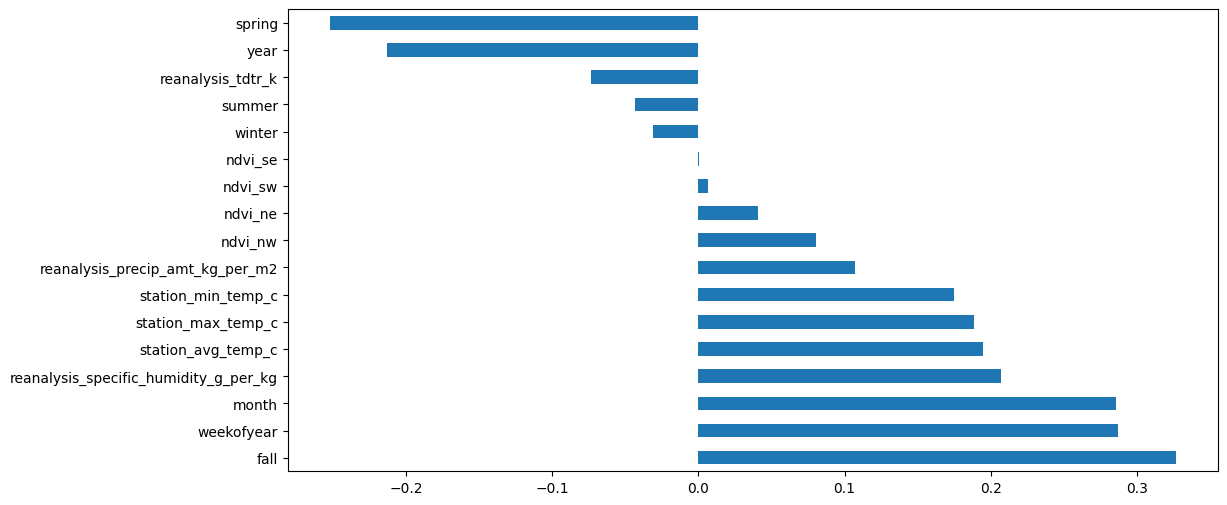

In [49]:
# See how these hand picked variables correlate with total cases
fig, ax = plt.subplots(figsize=(12,6))
train_featured.corr()['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh(ax=ax);

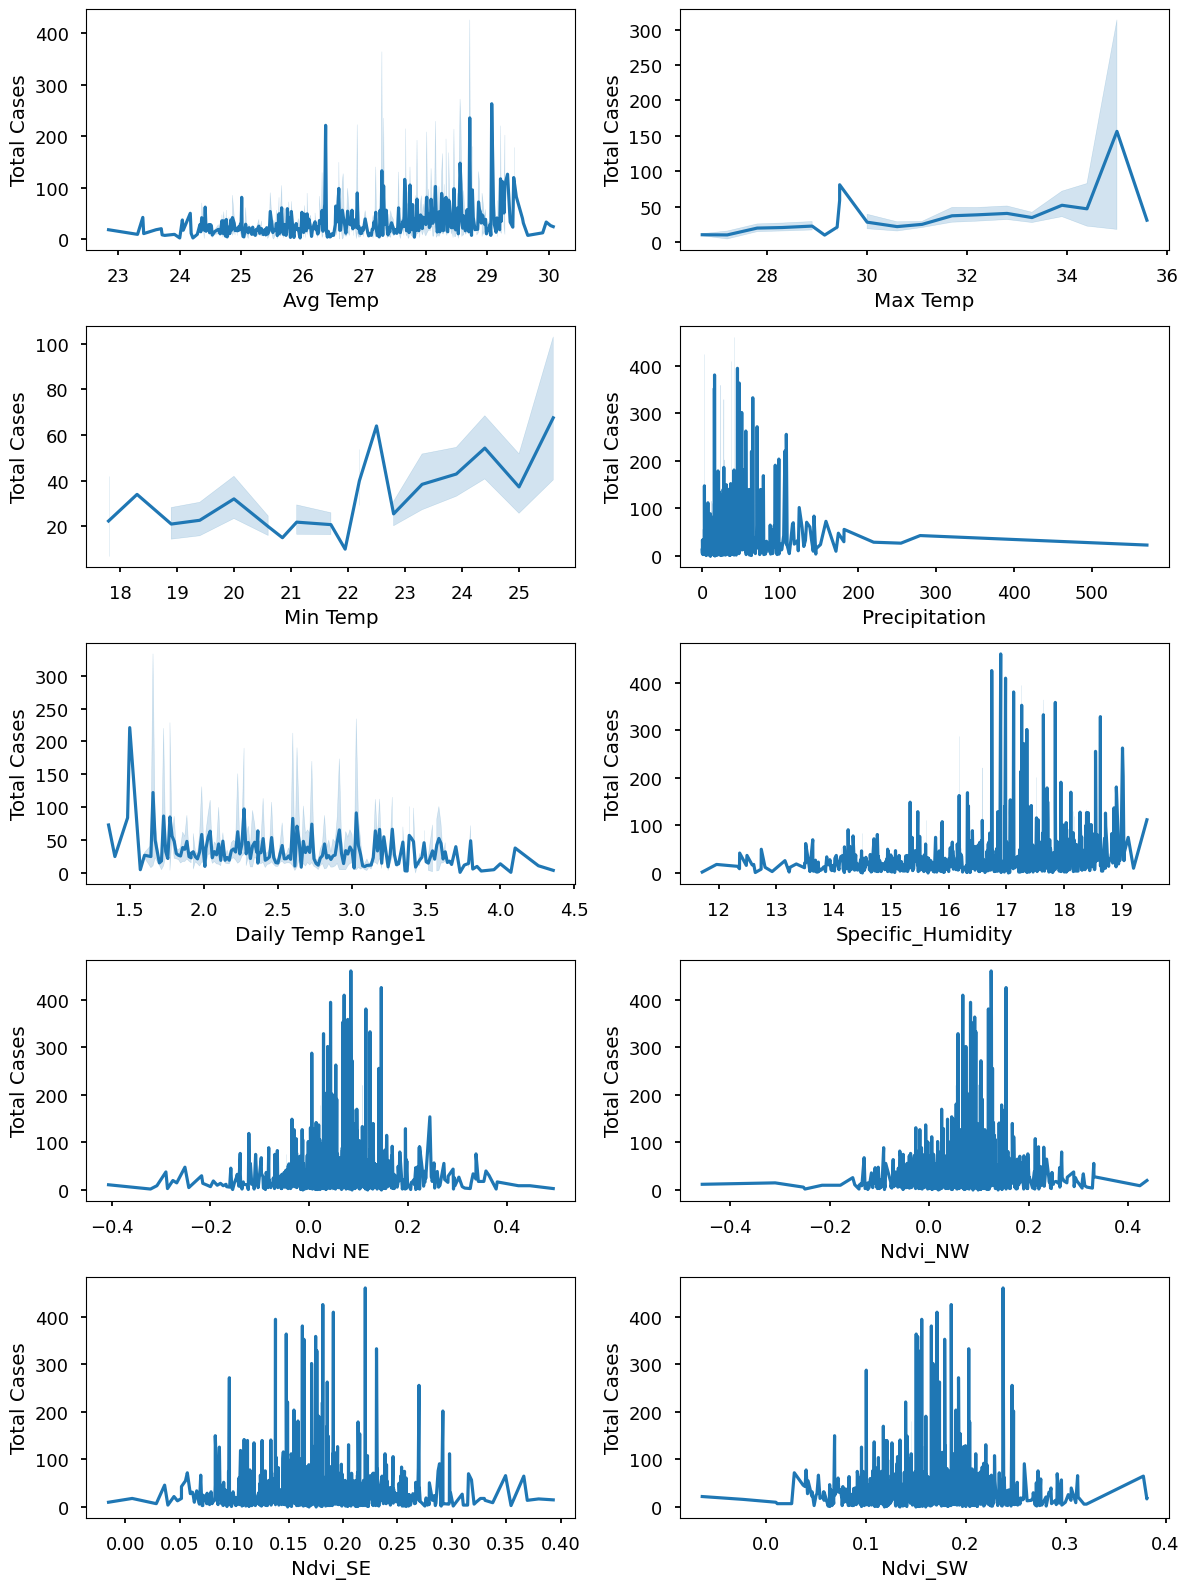

In [50]:
# Plot how the total case numbers differ based on each climate feature:
columns = ['station_avg_temp_c', 'station_max_temp_c',
           'station_min_temp_c', 'reanalysis_precip_amt_kg_per_m2',
           'reanalysis_tdtr_k', 'reanalysis_specific_humidity_g_per_kg',
           'ndvi_ne', 'ndvi_nw', 
           'ndvi_se', 'ndvi_sw']            
                    
labels = ["Avg Temp", "Max Temp", 
          "Min Temp", "Precipitation",
          "Daily Temp Range1", "Specific_Humidity", 
          "Ndvi NE", "Ndvi_NW", 
          "Ndvi_SE", "Ndvi_SW"]

nrows =5
ncols =2
with plt.style.context('seaborn-talk'):
    
    fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12,16))  

    j=0
    for i in range(nrows):
        for u in range(ncols):
            sns.lineplot(data =train_featured, x=columns[j], y="total_cases", ax = ax_list[i,u]) # need to use index for column because otherwise it does not itirate.
            ax_list[i,u].set_xlabel(labels[j])
            ax_list[i,u].set_ylabel("Total Cases")
            j = j+1
            
    fig.tight_layout();

* For all the variables, the relationship seems stronger until case number 100 reaches, possible because there are fewer extra high dengue cases.
* Extremely high **average temp**, **maximum temp**, **temp range**, or **precipitation** seem to impact dengue cases negatively. 
* There is no clear linear relationship between ndvi variables and total cases as lower and higher values tend to result in lower total cases, but moderate values tend to result in higher total cases.  


## Convert NDVI into Categorical variables:
* NDVI calculation range from -1 to 1. Negative values correspond to areas with water surfaces, manmade structures, rocks, clouds, snow. Bare soil usually falls within 0.1- 0.2 range. Plants will always have positive values between 0.2 and 1. Healthy, dense vegetation canopy should be above 0.5. Sparse vegetation will most likely fall within 0.2 to 0.5. 
* Since there is no clear linear relationship between ndvi and total cases, let's create a categorical version of the variables. |
  - Let's first create a new feature representing the average NDVI values from the four different locations. 
  - Then let's create a categorical version of the variable to represent **watery, soily, sparce_grassy** areas. 

In [51]:
# Create `ndvi_average` by taking the mean of all 4 coodinates. 
train_featured['ndvi_average'] =  (train_featured['ndvi_ne']+train_featured['ndvi_nw']+
                                   train_featured['ndvi_se']+train_featured['ndvi_sw'])/4


In [52]:
# Let's check the distibution of values:
train_featured[['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw', 'ndvi_average']].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,ndvi_average
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,0.057266,0.067853,0.177654,0.165855,0.117157
std,0.100001,0.090603,0.056694,0.055681,0.056231
min,-0.406250,-0.456100,-0.015533,-0.063457,-0.092565
25%,0.008050,0.018706,0.139862,0.129778,0.079570
50%,0.057667,0.068750,0.177171,0.165906,0.112724
75%,0.108288,0.115017,0.212336,0.202549,0.147122
max,0.493400,0.437100,0.393129,0.381420,0.342338


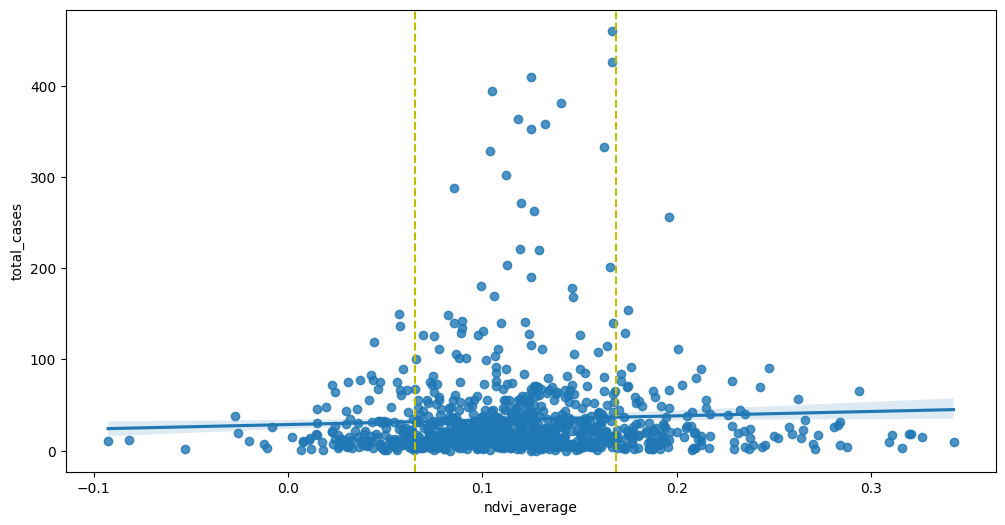

In [53]:
# Let's see the bottom and top 15th percentile for `ndvi_average`:
fig, ax = plt.subplots(figsize=(12,6))  
sns.regplot(data = train_featured, x='ndvi_average', y="total_cases", ax = ax)
ax.axvline(x=train_featured['ndvi_average'].quantile(0.15), ymin=0, ymax=1, color='y', linestyle='--')
ax.axvline(x=train_featured['ndvi_average'].quantile(0.85), ymin=0, ymax=1, color='y', linestyle='--');

* Total cases seem to be low for low and high ndvi, and high for moderate ndvi

In [54]:
# Create a function to transform `ndvi_average` into a categorical variables. 
# watery (dead plants) --> soily (unhealthy plants) --> grassy (healthy plants)
def get_ndvi_cat(x):
    if x < train_featured['ndvi_average'].quantile(0.15): 
        return "watery"
    if x >= train_featured['ndvi_average'].quantile(0.15) and x <= train_featured['ndvi_average'].quantile(0.85): 
        return "soily"
    else: 
        return "grassy"

In [55]:
# Apply the transformation
train_featured["ndvi_average_cat"] = train_featured["ndvi_average"].apply(get_ndvi_cat)

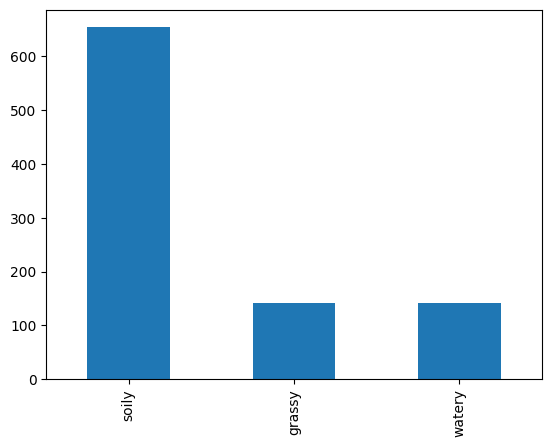

In [56]:
# See the count values after transformation
train_featured['ndvi_average_cat'].value_counts().plot(kind='bar');

In [57]:
# Get dummy codes for 'ndvi_average_cat` and merge with the dataset: 
ndvi_features = pd.get_dummies(train_featured['ndvi_average_cat'])
train_featured = pd.concat([train_featured, ndvi_features], axis = 1)
train_featured.head()

,total_cases,year,weekofyear,week_start_date,month,fall,spring,summer,winter,station_avg_temp_c,...,reanalysis_precip_amt_kg_per_m2,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,ndvi_average,ndvi_average_cat,grassy,soily,watery
0,4,1990.0,18.0,1990-04-30,4,0,1,0,0,25.442857,...,32.00,0.122600,0.103725,0.198483,0.177617,0.150606,soily,0,1,0
1,5,1990.0,19.0,1990-05-07,5,0,1,0,0,26.714286,...,17.94,0.169900,0.142175,0.162357,0.155486,0.157479,soily,0,1,0
2,4,1990.0,20.0,1990-05-14,5,0,1,0,0,26.714286,...,26.10,0.032250,0.172967,0.157200,0.170843,0.133315,soily,0,1,0
3,3,1990.0,21.0,1990-05-21,5,0,1,0,0,27.471429,...,13.90,0.128633,0.245067,0.227557,0.235886,0.209286,grassy,1,0,0
4,6,1990.0,22.0,1990-05-28,5,0,1,0,0,28.942857,...,12.20,0.196200,0.262200,0.251200,0.247340,0.239235,grassy,1,0,0


In [58]:
# Let's see if correlations improved:
ndvi_data = train_featured[['total_cases','ndvi_average','grassy'	,'soily'	,'watery']]
ndvi_data.corr()['total_cases']

total_cases     1.000000
ndvi_average    0.052466
grassy         -0.043124
soily           0.102880
watery         -0.088839
Name: total_cases, dtype: float64

## Create new shifted variables with rolled means:
* Research seems to indicated that past **sustained** heat, precipitation or humidity impacts dengue cases more profoundly than the climate situation right at the time of cases. 
* I will be creating a series of rolled means for each of the chosen variable.     
  - First shift the variables by 2 weeks to account for the growth of  mosquito and the incubation period of the virus until testing positive. 
  - Then create rolled - cumulative means with a range of lags to find the variable with the highest correlation. 

In [59]:
train_shifted = train_featured.copy()

In [60]:
# The variables to shift and roll:
shifted_varbls =['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c', 'reanalysis_tdtr_k',
                 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_precip_amt_kg_per_m2',
                 'grassy', 'soily','watery']


In [61]:
# shift the variables two weeks ahead so that total cases would correspond with climate variables from two weeks ago:
for var in shifted_varbls:
    train_shifted[f"{var}_shift"] = train_shifted[var].shift(2)
# drop the two rows with NA   
train_shifted.dropna(axis=0, inplace=True)
# reset the index
train_shifted = train_shifted.reset_index(drop=True)

In [62]:
# Making sure it shifted corretly
train_shifted[['year', 'weekofyear','week_start_date', 'station_avg_temp_c', 'station_avg_temp_c_shift',  'grassy', 'grassy_shift']].head()

,year,weekofyear,week_start_date,station_avg_temp_c,station_avg_temp_c_shift,grassy,grassy_shift
0,1990.0,20.0,1990-05-14,26.714286,25.442857,0,0.0
1,1990.0,21.0,1990-05-21,27.471429,26.714286,1,0.0
2,1990.0,22.0,1990-05-28,28.942857,26.714286,1,0.0
3,1990.0,23.0,1990-06-04,28.114286,27.471429,1,1.0
4,1990.0,24.0,1990-06-11,27.414286,28.942857,0,1.0


In [63]:
# create another copy to get the rolled means
train_rolled = train_shifted.copy()

In [64]:
# We will check the correlations between these variables and its shifted versions
varbls_to_see_lags = ['total_cases',
                             'reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_specific_humidity_g_per_kg', 
                             'reanalysis_tdtr_k',
                             'station_avg_temp_c', 
                             'station_max_temp_c',
                             'station_min_temp_c', 
                             'grassy', 'soily','watery',
                             'reanalysis_precip_amt_kg_per_m2_shift',
                             'reanalysis_specific_humidity_g_per_kg_shift', 
                             'reanalysis_tdtr_k_shift',
                             'station_avg_temp_c_shift', 
                             'station_max_temp_c_shift',
                             'station_min_temp_c_shift', 
                             'grassy_shift', 'soily_shift','watery_shift']

In [65]:
train_rolled = train_rolled[varbls_to_see_lags]

In [66]:
rolled_varbls = ['reanalysis_precip_amt_kg_per_m2_shift',
                 'reanalysis_specific_humidity_g_per_kg_shift', 
                 'reanalysis_tdtr_k_shift',
                 'station_avg_temp_c_shift', 
                 'station_max_temp_c_shift',
                 'station_min_temp_c_shift', 
                 'grassy_shift', 'soily_shift','watery_shift']

In [67]:
# Create cumulative means for lags of 2 through 20 weeks (about 3-4 months):
# Use a min period of 10 for a lag of 20 so we do not lose all the first 20 weeks of data. 
window = np.linspace(2,20,10).astype(int)
min_periods = np.linspace(1,10,10).astype(int)

for var in rolled_varbls:
    for num,min in zip(window,min_periods):
        train_rolled[f"{var}_{num}"] = train_rolled[var].rolling(window = num, min_periods = min).mean()

In [68]:
# Create 4 seperate datasets for temp, humid, prec, ndvi variables with shifted and rolled versions:
temp_cols = [col for col in train_rolled.columns if 'temp' in col or 'tdtr' in col]
hum_cols = [col for col in train_rolled.columns if 'hum' in col]
prec_cols = [col for col in train_rolled.columns if 'prec' in col]
ndvi_cols = [col for col in train_rolled.columns if 'grassy' in col or 'soily' in col or 'watery' in col]


In [94]:
# Add total_cases
temp = train_rolled[temp_cols]
temp['total_cases'] = train_rolled['total_cases']

hum = train_rolled[hum_cols]
hum['total_cases'] = train_rolled['total_cases']

prec = train_rolled[prec_cols]
prec['total_cases'] = train_rolled['total_cases']

ndvi = train_rolled[ndvi_cols]
ndvi['total_cases'] = train_rolled['total_cases']

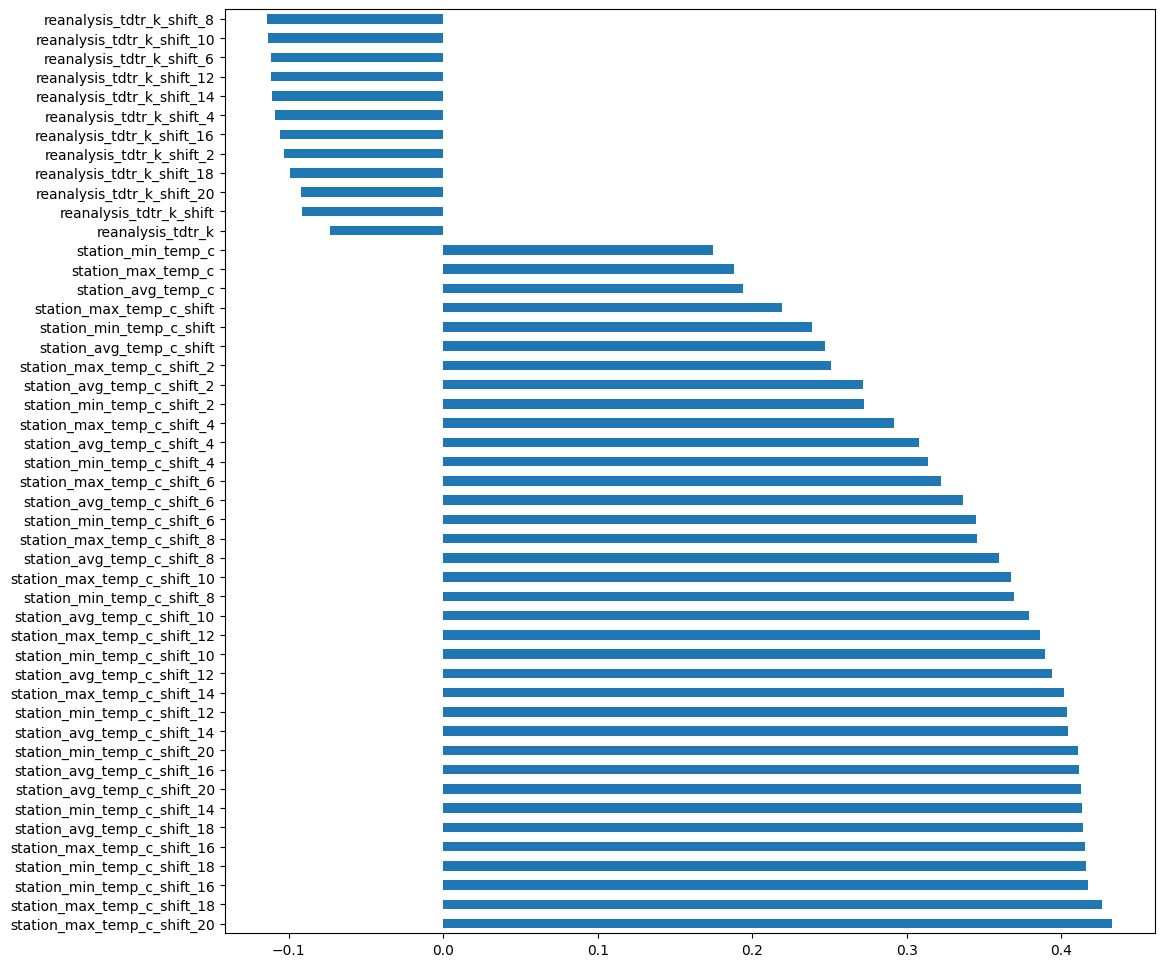

In [70]:
# see the correlations between all temperature variables along with their lagged versions and total case counts
fig, ax = plt.subplots(figsize=(12,12))
temp.corr()['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh(ax=ax);

In [71]:
# create a function to see how lagged versions of a variable is related to total cases. 
def lag_graph(df, var):

    columns = [f"{var}", f"{var}_shift", 
               f"{var}_shift_2", f"{var}_shift_4",
               f"{var}_shift_6", f"{var}_shift_8",
               f"{var}_shift_10", f"{var}_shift_12", 
               f"{var}_shift_14", f"{var}_shift_16",
               f"{var}_shift_18", f"{var}_shift_20"]
   
    labels = ["original", "shift_2", "shift_2 + roll_2", "shift_2 + roll_4", "shift_2 + roll_6", 
              "shift_2 + roll_8","shift_2 + roll_10", "shift_2 + roll_12", "shift_2 + roll_14", 
              "shift_2 + roll_16", "shift_2 + roll_18", "shift_2 + roll_20"]

    ncols = 2
    nrows = 6
    with plt.style.context('seaborn-talk'):

    
        fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12,16))  

        j=0
        for i in range(nrows):
            for u in range(ncols):
                sns.lineplot(data = df, x=columns[j], y="total_cases", ax = ax_list[i,u]) # need to use index for column because otherwise it does not itirate.
                ax_list[i,u].set_xlabel(labels[j])
                ax_list[i,u].set_ylabel("Total Cases")
                j = j+1
            
        fig.tight_layout();

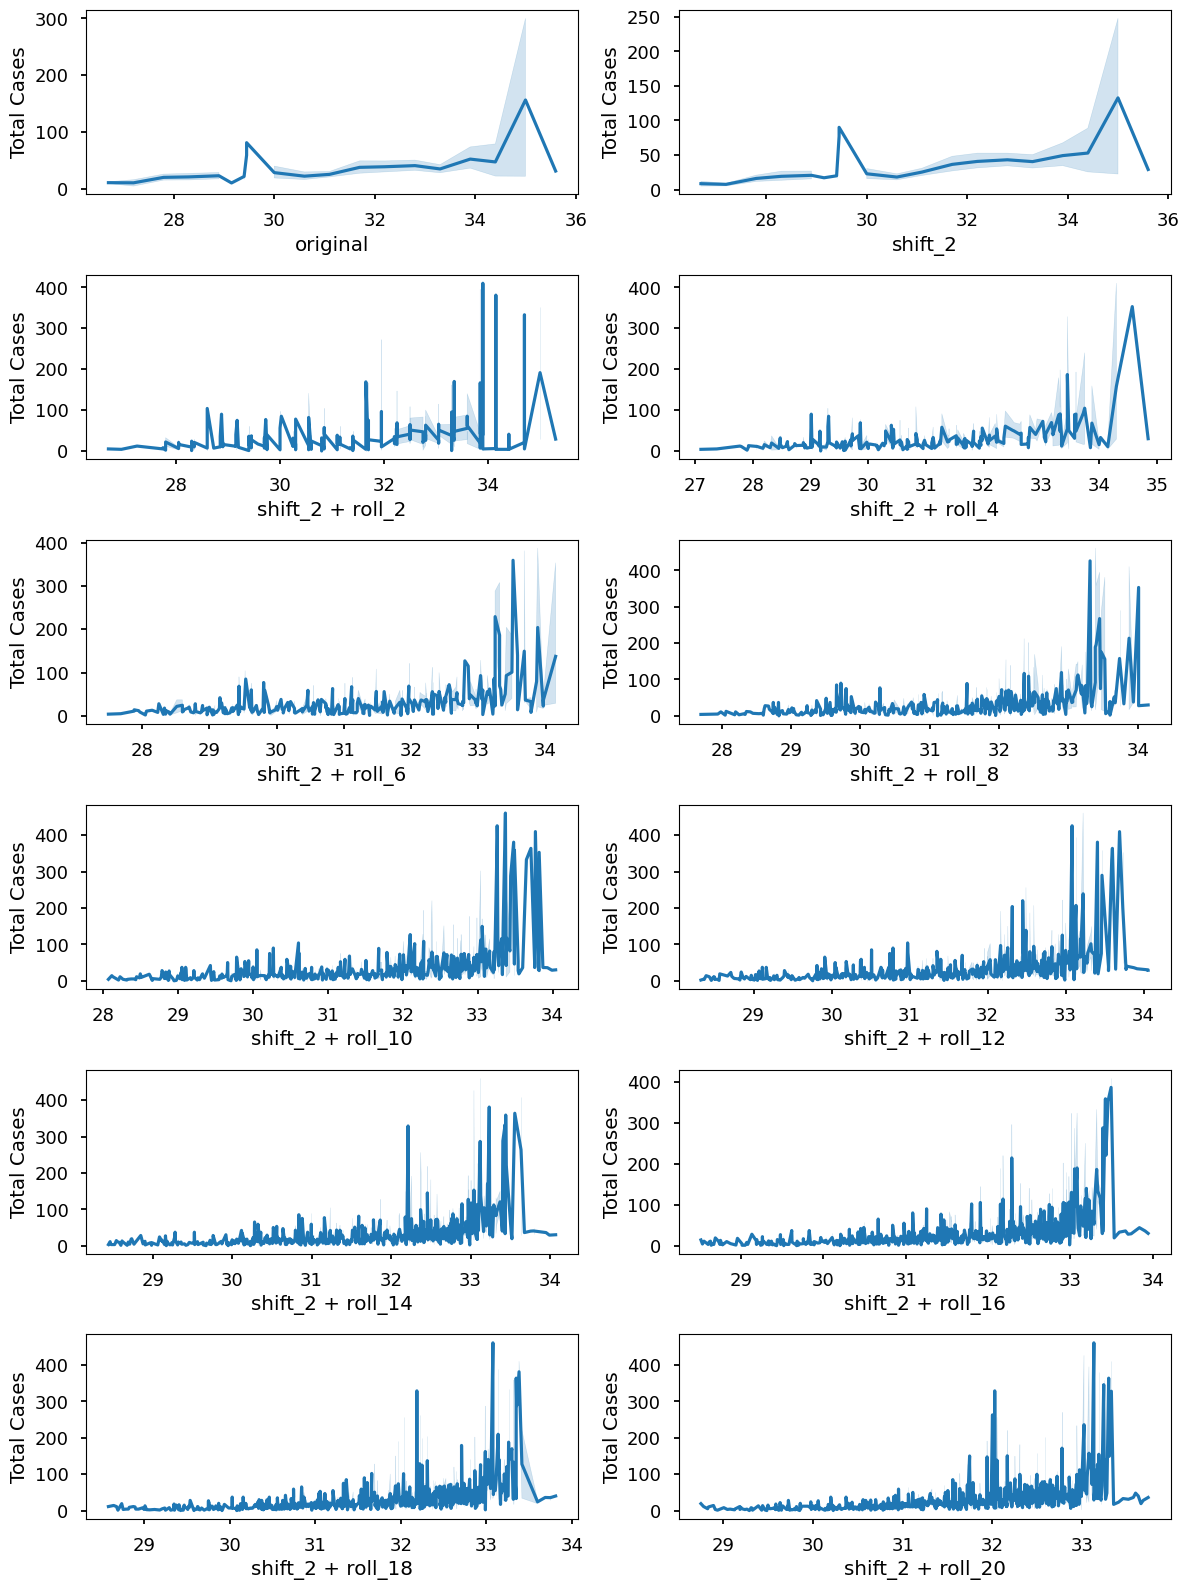

In [72]:
lag_graph(train_rolled, "station_max_temp_c")

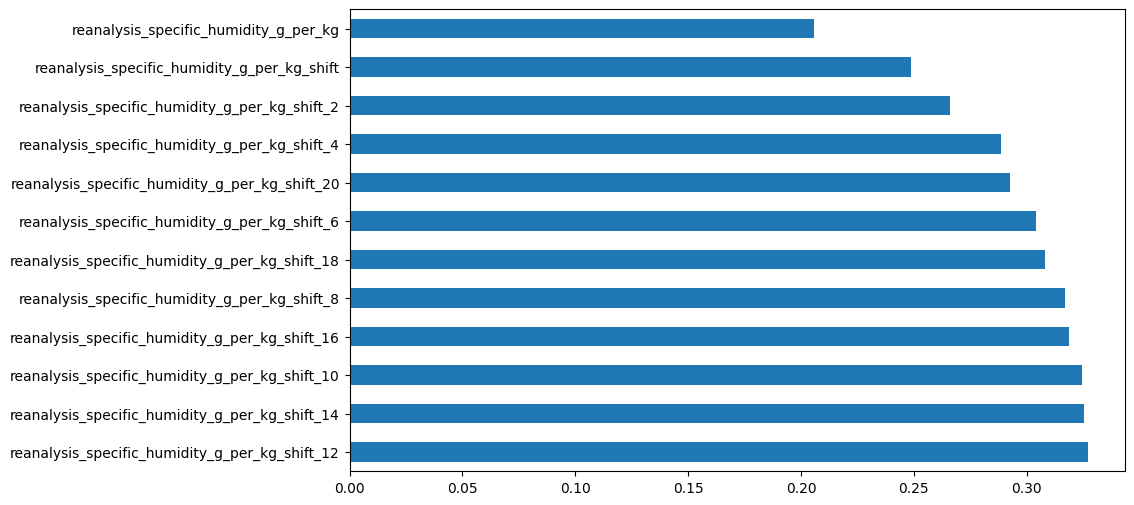

In [73]:
# see the correlations between the humidity variable along with its lagged versions and total case counts
fig, ax = plt.subplots(figsize=(10,6))
hum.corr()['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh(ax=ax);

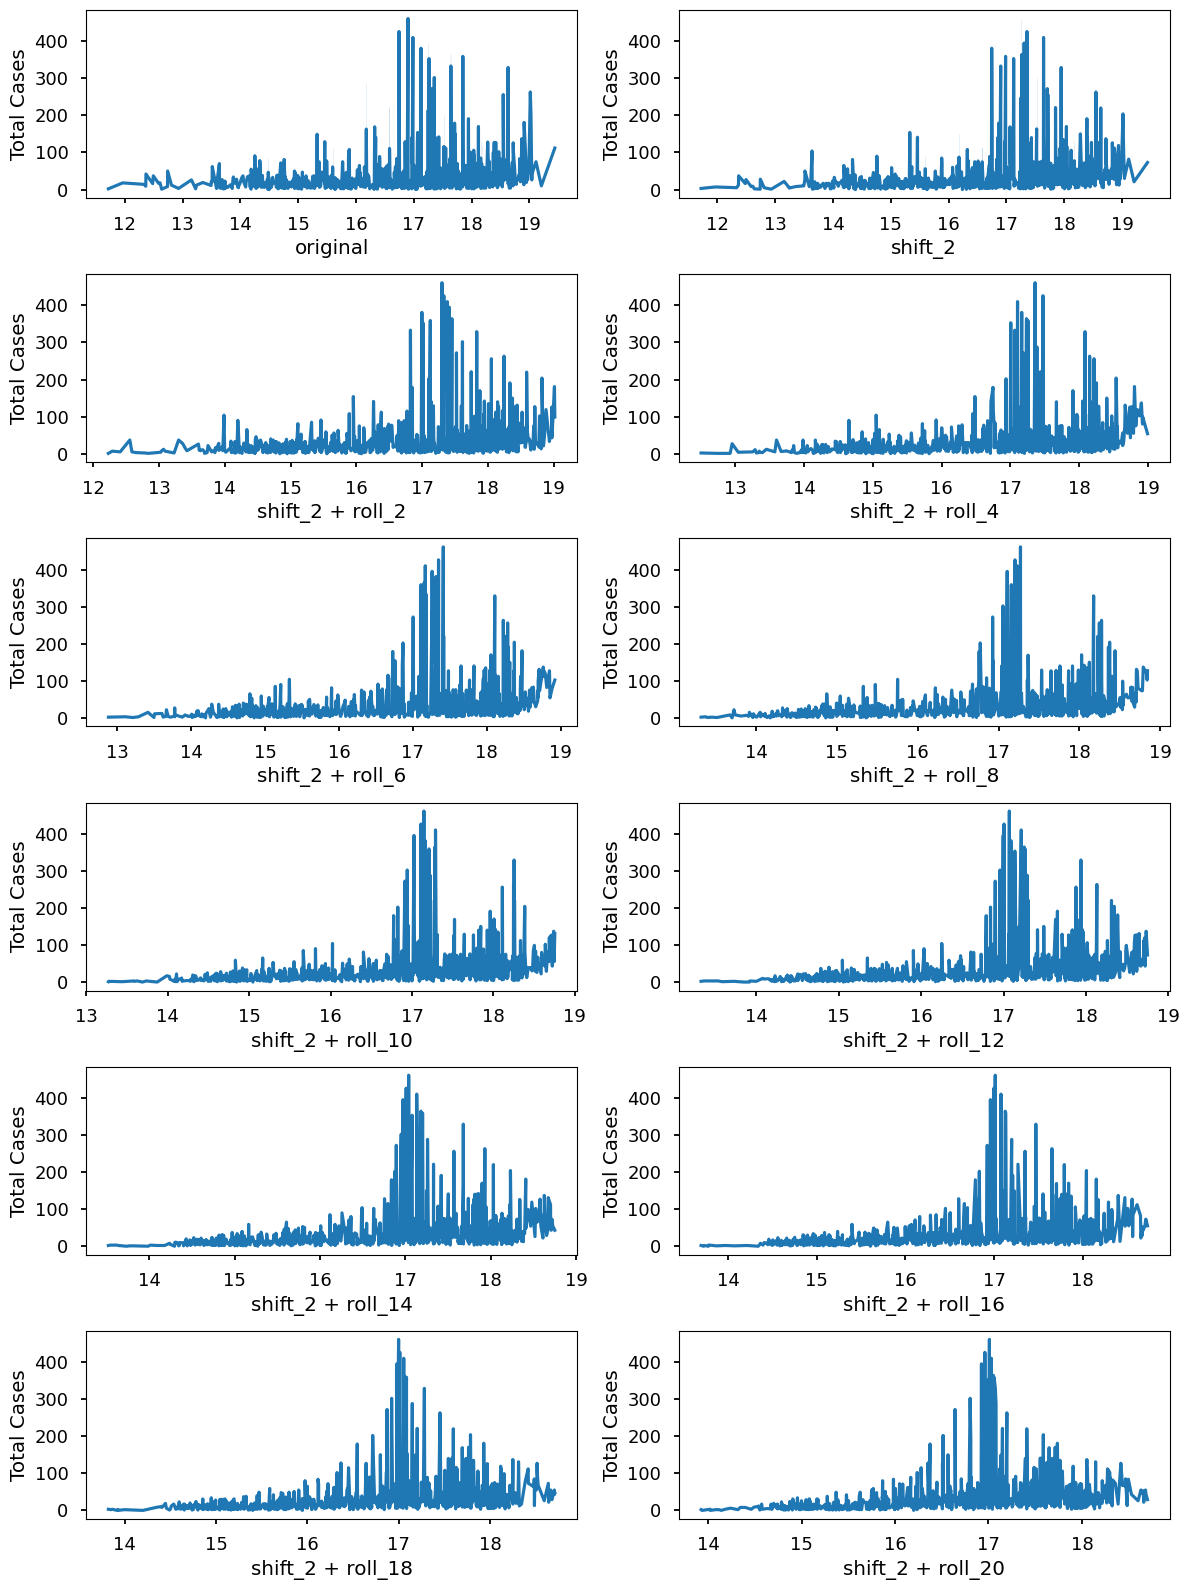

In [74]:
lag_graph(train_rolled, "reanalysis_specific_humidity_g_per_kg")  

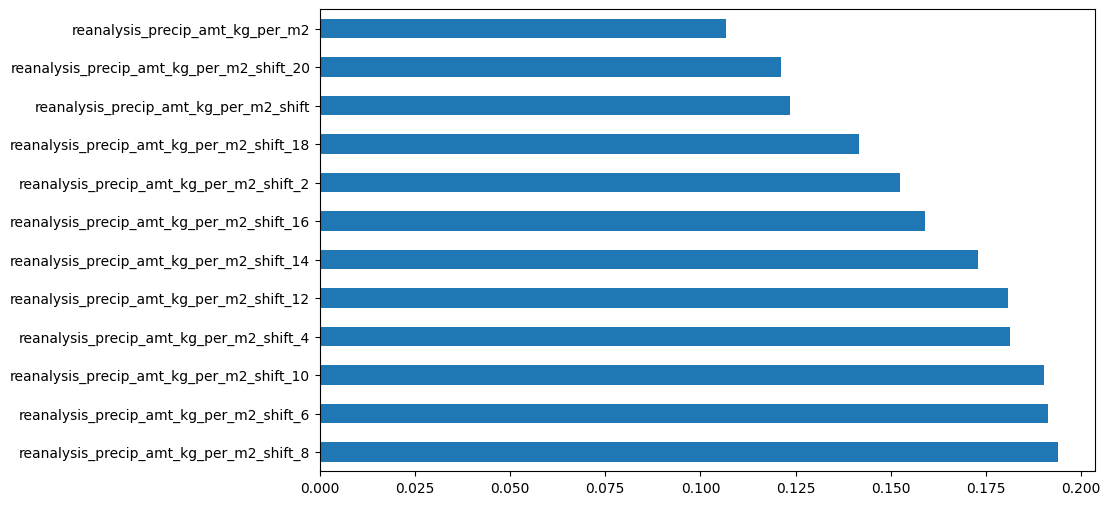

In [75]:
# see the correlations between the precipitation variable along with its lagged versions and total case counts
fig, ax = plt.subplots(figsize=(10,6))
prec.corr()['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh(ax=ax);

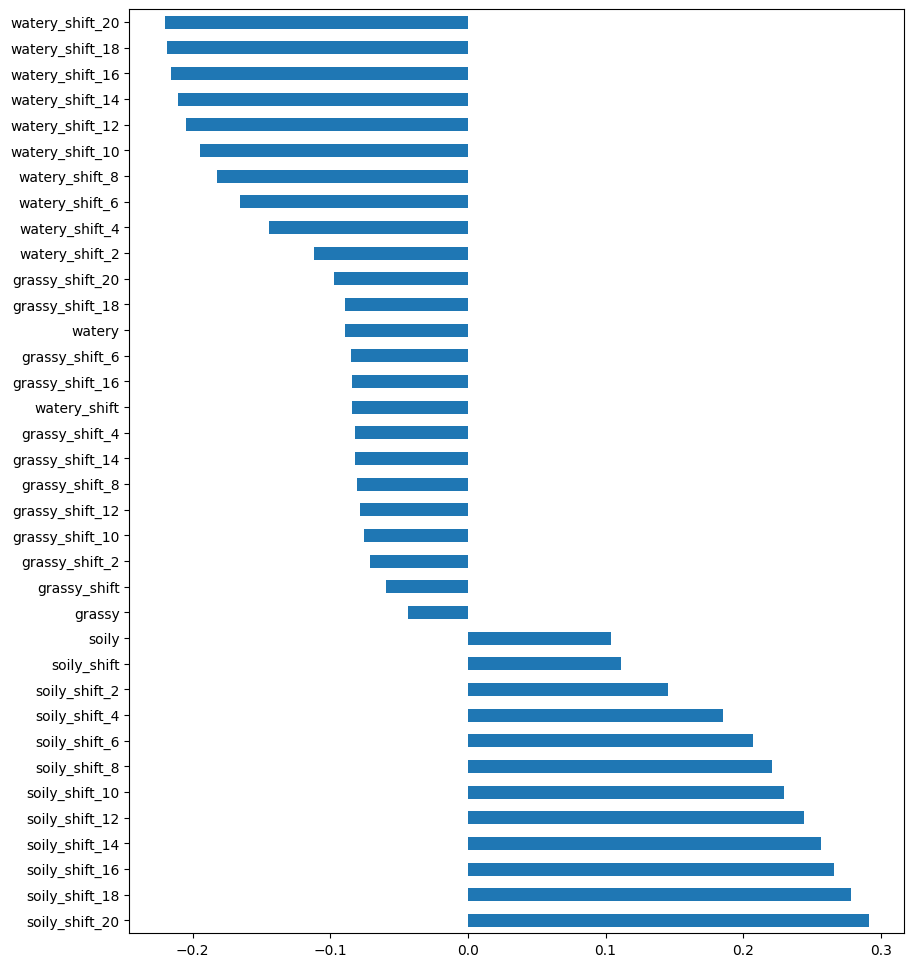

In [76]:
# see the correlations between the vegetation variables along with their lagged versions and total case counts
fig, ax = plt.subplots(figsize=(10,12))
ndvi.corr()['total_cases'].drop('total_cases').sort_values(ascending=False).plot.barh(ax=ax);

# Based on above graphs I will be using these variables which provided the highest correlations to total cases:

* `station_max_temp_c_shift_18`,
* `station_min_temp_c_shift_18`, 
* `station_avg_temp_c_shift_18`, 
* `reanalysis_tdtr_k_shift_8`, 
* `reanalysis_specific_humidity_g_per_kg_shift_12`,
* `reanalysis_precip_amt_kg_per_m2_shift_8`,
* `grassy_shift_20`,
* `soily_shift_20`,
* `watery_shift_20`

In [77]:
rolled_varbls_to_use = ['station_max_temp_c_shift_18',
                        'station_min_temp_c_shift_18', 
                        'station_avg_temp_c_shift_18', 
                        'reanalysis_tdtr_k_shift_8', 
                        'reanalysis_specific_humidity_g_per_kg_shift_12',
                        'reanalysis_precip_amt_kg_per_m2_shift_8',
                        'grassy_shift_20',
                        'soily_shift_20','watery_shift_20']

In [79]:
# Add the rolled variables to the dataset
train_final = train_shifted.join(train_rolled[rolled_varbls_to_use])
train_final.head(10)

,total_cases,year,weekofyear,week_start_date,month,fall,spring,summer,winter,station_avg_temp_c,...,watery_shift,station_max_temp_c_shift_18,station_min_temp_c_shift_18,station_avg_temp_c_shift_18,reanalysis_tdtr_k_shift_8,reanalysis_specific_humidity_g_per_kg_shift_12,reanalysis_precip_amt_kg_per_m2_shift_8,grassy_shift_20,soily_shift_20,watery_shift_20
0,4,1990.0,20.0,1990-05-14,5,0,1,0,0,26.714286,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,1990.0,21.0,1990-05-21,5,0,1,0,0,27.471429,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,1990.0,22.0,1990-05-28,5,0,1,0,0,28.942857,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1990.0,23.0,1990-06-04,6,0,0,1,0,28.114286,...,0.0,NaN,NaN,NaN,2.432143,NaN,22.485000,NaN,NaN,NaN
4,4,1990.0,24.0,1990-06-11,6,0,0,1,0,27.414286,...,0.0,NaN,NaN,NaN,2.548571,NaN,20.428000,NaN,NaN,NaN
5,5,1990.0,25.0,1990-06-18,6,0,0,1,0,28.371429,...,0.0,NaN,NaN,NaN,2.473810,16.221667,21.438333,NaN,NaN,NaN
6,10,1990.0,26.0,1990-06-25,6,0,0,1,0,28.328571,...,0.0,NaN,NaN,NaN,2.412245,16.366327,23.890000,NaN,NaN,NaN
7,6,1990.0,27.0,1990-07-02,7,0,0,1,0,28.328571,...,0.0,NaN,NaN,NaN,2.307143,16.567679,24.653750,NaN,NaN,NaN
8,8,1990.0,28.0,1990-07-09,7,0,0,1,0,27.557143,...,0.0,32.888889,22.777778,27.501587,2.214286,16.703492,25.342500,NaN,NaN,NaN
9,2,1990.0,29.0,1990-07-16,7,0,0,1,0,28.128571,...,0.0,32.990000,22.940000,27.584286,2.169643,16.840286,26.650000,0.3,0.7,0.0


In [80]:
# We are losing the first 9 rows 
train_final = train_final.dropna().reset_index(drop=True)

In [81]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 42 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   total_cases                                     925 non-null    int64         
 1   year                                            925 non-null    float64       
 2   weekofyear                                      925 non-null    float64       
 3   week_start_date                                 925 non-null    datetime64[ns]
 4   month                                           925 non-null    int64         
 5   fall                                            925 non-null    uint8         
 6   spring                                          925 non-null    uint8         
 7   summer                                          925 non-null    uint8         
 8   winter                                          92

## Repeat all steps for the final test set:
* First add the last 21 (19 +2 for shifting) rows of the train_full to test_full to not to lose the first part of the dataset while transforming

In [85]:
# Add week_start_date to both datasets
test_features_full['week_start_date'] = test_features['week_start_date']
train_features_full['week_start_date'] = train_features['week_start_date']

In [86]:
test_features_long = pd.concat([train_features_full.tail(21), test_features_full],ignore_index=True)
test_features_long

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,week_start_date
0,2007.0,49.0,-0.03976,-0.042350,0.095600,0.089000,17.85,299.020000,299.021429,294.288571,...,75.368571,17.85,15.675714,2.100000,25.842857,5.400000,29.4,22.8,34.5,12/3/07
1,2007.0,50.0,-0.13305,-0.045550,0.151440,0.143171,31.30,298.900000,298.971429,294.774286,...,78.015714,31.30,16.130000,2.485714,25.771429,5.085714,28.9,22.2,30.2,12/10/07
2,2007.0,51.0,0.02945,-0.039000,0.173417,0.150171,62.11,298.668571,298.757143,294.977143,...,80.178571,62.11,16.344286,2.371429,25.071429,4.914286,28.9,21.7,108.2,12/17/07
3,2007.0,52.0,0.01480,0.016300,0.207267,0.144578,0.00,298.602857,298.750000,293.928571,...,75.448571,0.00,15.318571,2.985714,25.085714,6.242857,28.3,21.1,16.8,12/24/07
4,2008.0,1.0,0.00060,-0.309600,0.239814,0.195557,0.00,298.038571,298.121429,293.514286,...,76.148571,0.00,14.911429,1.842857,25.400000,5.300000,29.4,22.2,55.5,1/1/08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2013.0,13.0,-0.08740,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,...,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5,3/26/13
277,2013.0,14.0,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,...,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6,4/2/13
278,2013.0,15.0,-0.11760,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,...,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4,4/9/13
279,2013.0,16.0,0.08275,0.031200,0.135014,0.074857,0.00,298.912857,299.064286,294.678571,...,77.674286,0.00,15.965714,3.042857,27.728571,6.942857,31.7,23.9,22.9,4/16/13


In [87]:
# create a new month variable:

test_featured = test_features_long.copy()
test_featured["week_start_date"] = pd.to_datetime(test_featured["week_start_date"])
test_featured['month'] = test_featured['week_start_date'].dt.month

# create a new season variable:
test_featured['season'] = test_featured['month'].map(month_to_season) 
season_features = pd.get_dummies(test_featured['season'])
test_featured = pd.concat([test_featured, season_features], axis = 1)

test_featured = test_featured[['year', 'weekofyear', 'week_start_date', 
                                 'month',  'fall', 'spring', 'summer','winter',
                                 'station_avg_temp_c', 'station_max_temp_c',
                                 'station_min_temp_c', 'reanalysis_tdtr_k',
                                 'reanalysis_specific_humidity_g_per_kg',
                                 'reanalysis_precip_amt_kg_per_m2',
                                 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']]


test_featured['ndvi_average'] =  (test_featured['ndvi_ne']+test_featured['ndvi_nw']+
                                   test_featured['ndvi_se']+test_featured['ndvi_sw'])/4

test_featured["ndvi_average_cat"] = test_featured["ndvi_average"].apply(get_ndvi_cat)

ndvi_features = pd.get_dummies(test_featured['ndvi_average_cat'])
test_featured = pd.concat([test_featured, ndvi_features], axis = 1)

# shift by 2 weeks
test_shifted = test_featured.copy()

for var in shifted_varbls:
    test_shifted[f"{var}_shift"] = test_shifted[var].shift(2)
    
test_shifted.dropna(axis=0, inplace=True)
# test_shifted = test_shifted.reset_index(drop=True)

# get rolled means
test_rolled = test_shifted.copy()

varbls_to_see_lags = ['reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_specific_humidity_g_per_kg', 
                             'reanalysis_tdtr_k',
                             'station_avg_temp_c', 
                             'station_max_temp_c',
                             'station_min_temp_c', 
                             'grassy', 'soily','watery',
                             'reanalysis_precip_amt_kg_per_m2_shift',
                             'reanalysis_specific_humidity_g_per_kg_shift', 
                             'reanalysis_tdtr_k_shift',
                             'station_avg_temp_c_shift', 
                             'station_max_temp_c_shift',
                             'station_min_temp_c_shift', 
                             'grassy_shift', 'soily_shift','watery_shift']

test_rolled = test_rolled[varbls_to_see_lags]



for var in rolled_varbls:
    for num in window:
        test_rolled[f"{var}_{num}"] = test_rolled[var].rolling(num).mean()

rolled_varbls_to_use = ['station_avg_temp_c_shift', 
                        'station_max_temp_c_shift',
                        'station_min_temp_c_shift', 
                        'reanalysis_precip_amt_kg_per_m2_shift',
                        'reanalysis_specific_humidity_g_per_kg_shift', 
                        'reanalysis_tdtr_k_shift',
                        'grassy_shift', 'soily_shift','watery_shift',
                        'station_max_temp_c_shift_18',
                        'station_min_temp_c_shift_18', 
                        'station_avg_temp_c_shift_18', 
                        'reanalysis_tdtr_k_shift_8', 
                        'reanalysis_specific_humidity_g_per_kg_shift_12',
                        'reanalysis_precip_amt_kg_per_m2_shift_8',
                        'grassy_shift_20',
                        'soily_shift_20','watery_shift_20']

test_final = test_featured.join(test_rolled[rolled_varbls_to_use])
test_final = test_final.dropna().reset_index(drop=True)
test_final


,year,weekofyear,week_start_date,month,fall,spring,summer,winter,station_avg_temp_c,station_max_temp_c,...,watery_shift,station_max_temp_c_shift_18,station_min_temp_c_shift_18,station_avg_temp_c_shift_18,reanalysis_tdtr_k_shift_8,reanalysis_specific_humidity_g_per_kg_shift_12,reanalysis_precip_amt_kg_per_m2_shift_8,grassy_shift_20,soily_shift_20,watery_shift_20
0,2008.0,18.0,2008-04-29,4,0,1,0,0,26.528571,33.3,...,0.0,28.816667,21.300000,24.997619,2.678571,14.065833,9.28500,0.0,0.50,0.50
1,2008.0,19.0,2008-05-06,5,0,1,0,0,26.071429,30.0,...,1.0,28.972222,21.388889,25.107143,2.887500,14.171071,8.74875,0.0,0.50,0.50
2,2008.0,20.0,2008-05-13,5,0,1,0,0,27.928571,32.8,...,1.0,29.250000,21.422222,25.187302,2.951786,14.395476,11.10750,0.0,0.50,0.50
3,2008.0,21.0,2008-05-20,5,0,1,0,0,28.057143,33.3,...,1.0,29.283333,21.422222,25.224603,3.012500,14.514167,12.66375,0.0,0.45,0.55
4,2008.0,22.0,2008-05-27,5,0,1,0,0,27.614286,33.3,...,0.0,29.533333,21.516667,25.388889,3.082143,14.692143,13.06625,0.0,0.45,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2013.0,13.0,2013-03-26,3,0,1,0,0,27.542857,33.9,...,0.0,30.766667,22.377778,26.509524,2.723214,14.662024,7.32500,0.0,0.60,0.40
256,2013.0,14.0,2013-04-02,4,0,1,0,0,26.642857,33.3,...,1.0,30.550000,22.194444,26.352381,2.775000,14.439048,6.88750,0.0,0.55,0.45
257,2013.0,15.0,2013-04-09,4,0,1,0,0,27.914286,32.8,...,1.0,30.611111,22.105556,26.298413,2.891071,14.439524,6.24375,0.0,0.55,0.45
258,2013.0,16.0,2013-04-16,4,0,1,0,0,27.728571,31.7,...,1.0,30.733333,22.016667,26.227778,2.910714,14.490000,12.39375,0.0,0.50,0.50


In [88]:
# Making sure test_final has the same length with older version
len(test_features_full) ==  len(test_final)

True

In [89]:
# Making sure test_final follows train_final corrretly in terms of date
print(train_final['week_start_date'])
print('----------------')
print(test_final['week_start_date'])

0     1990-07-16
1     1990-07-23
2     1990-07-30
3     1990-08-06
4     1990-08-13
         ...    
920   2008-03-25
921   2008-04-01
922   2008-04-08
923   2008-04-15
924   2008-04-22
Name: week_start_date, Length: 925, dtype: datetime64[ns]
----------------
0     2008-04-29
1     2008-05-06
2     2008-05-13
3     2008-05-20
4     2008-05-27
         ...    
255   2013-03-26
256   2013-04-02
257   2013-04-09
258   2013-04-16
259   2013-04-23
Name: week_start_date, Length: 260, dtype: datetime64[ns]


In [90]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 42 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   total_cases                                     925 non-null    int64         
 1   year                                            925 non-null    float64       
 2   weekofyear                                      925 non-null    float64       
 3   week_start_date                                 925 non-null    datetime64[ns]
 4   month                                           925 non-null    int64         
 5   fall                                            925 non-null    uint8         
 6   spring                                          925 non-null    uint8         
 7   summer                                          925 non-null    uint8         
 8   winter                                          92

In [91]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 41 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   year                                            260 non-null    float64       
 1   weekofyear                                      260 non-null    float64       
 2   week_start_date                                 260 non-null    datetime64[ns]
 3   month                                           260 non-null    int64         
 4   fall                                            260 non-null    uint8         
 5   spring                                          260 non-null    uint8         
 6   summer                                          260 non-null    uint8         
 7   winter                                          260 non-null    uint8         
 8   station_avg_temp_c                              26

In [92]:
# Export the final datasets as csv to be used for modeling
train_final.to_csv("train_final.csv")
test_final.to_csv("test_final.csv")

### Export as PDF:

In [ ]:
# Packages required for using nbconvert PDF
# ! apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# ! pip install pypandoc
# ! pip install nbconvert

In [ ]:
# First you need to download a copy of the ipynb notebook and upload it back to the drive, it is placed under /content/
# ! jupyter nbconvert --to pdf /content/notebook_preprocessing.ipynb